In [1]:
import numpy as np
import scipy.io as scio
from os import path
from scipy import signal
import os

path_Extracted = 'D:/Python/Major_Project/dataset/mat_data/ISRUC_S3_mat'
path_RawData   = 'D:/Python/Major_Project/data/ISRUC_S3/RawData/RawData'
path_output    = 'D:/Python/Major_Project/data'
channels = ['C3_A2', 'C4_A1', 'F3_A2', 'F4_A1', 'O1_A2', 'O2_A1',
            'LOC_A2', 'ROC_A1', 'X1', 'X2']

def read_psg(path_Extracted, sub_id, channels, resample=3000):
    psg = scio.loadmat(path.join(path_Extracted, 'subject%d.mat' % (sub_id)))
    psg_use = []
    for c in channels:
        psg_use.append(
            np.expand_dims(signal.resample(psg[c], resample, axis=-1), 1))
    psg_use = np.concatenate(psg_use, axis=1)
    return psg_use

def read_label(path_RawData, sub_id, ignore=30):
    label = []
    with open(path.join(path_RawData, '%d/%d_1.txt' % (sub_id, sub_id))) as f:
        s = f.readline()
        while True:
            a = s.replace('\n', '')
            label.append(int(a))
            s = f.readline()
            if s == '' or s == '\n':
                break
    return np.array(label[:-ignore])

fold_label = []
fold_psg = []
fold_len = []

for sub in range(1, 11):
    print('Read subject', sub)
    labels = read_label(path_RawData, sub)
    psg = read_psg(path_Extracted, sub, channels)
    print('Subject', sub, ':', labels.shape, psg.shape)
    assert len(labels) == len(psg)

    # Label Mapping
    apnea_labels = np.copy(labels)
    apnea_labels[np.isin(labels, [0, 2, 3])] = 0  # Normal: W, N2, N3
    apnea_labels[np.isin(labels, [1])] = 1  # OSA: N1
    apnea_labels[np.isin(labels, [5])] = 2  # CSA: REM

    fold_label.append(np.eye(3)[apnea_labels])  # One-hot encoding with 3 classes
    fold_psg.append(psg)
    fold_len.append(len(labels))

print('Preprocess over.')

os.makedirs(path_output, exist_ok=True)  # Ensure directory exists

np.savez(os.path.join(path_output, 'ISRUC_S3.npz'),
    Fold_data=np.array(fold_psg, dtype=object),  
    Fold_label=np.array(fold_label, dtype=object),  
    Fold_len=np.array(fold_len)  
)

print('Saved to', os.path.join(path_output, 'ISRUC_S3.npz'))


Read subject 1
Subject 1 : (924,) (924, 10, 3000)
Read subject 2
Subject 2 : (911,) (911, 10, 3000)
Read subject 3
Subject 3 : (794,) (794, 10, 3000)
Read subject 4
Subject 4 : (764,) (764, 10, 3000)
Read subject 5
Subject 5 : (914,) (914, 10, 3000)
Read subject 6
Subject 6 : (823,) (823, 10, 3000)
Read subject 7
Subject 7 : (784,) (784, 10, 3000)
Read subject 8
Subject 8 : (970,) (970, 10, 3000)
Read subject 9
Subject 9 : (939,) (939, 10, 3000)
Read subject 10
Subject 10 : (766,) (766, 10, 3000)
Preprocess over.
Saved to D:/Python/Major_Project/data\ISRUC_S3.npz


In [2]:
import os
import numpy as np
import argparse
import shutil
import gc

import keras
import tensorflow as tf
from keras import backend as KTF

from model.FeatureNet import build_FeatureNet
from model.DataGenerator import kFoldGenerator
from model.Utils import ReadConfig

# Display a header
print(128 * '#')
print('Start to train FeatureNet.')

# Configuration Setup
parser = argparse.ArgumentParser()
# parser.add_argument("-c", type=str, help="Configuration file", required=True)
# parser.add_argument("-g", type=str, help="GPU number to use, set '-1' to use CPU", required=True)
# args = parser.parse_args()
args = lambda: None
args.c = "./ISRUC.config"  # Update with your actual path
args.g = "-1"  # Change this based on whether you want to use a GPU or CPU

Path, cfgFeature, _, _ = ReadConfig(args.c)

# Set GPU or CPU
os.environ["CUDA_VISIBLE_DEVICES"] = args.g
if args.g != "-1":
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=config)
    print("Use GPU #" + args.g)
else:
    print("Use CPU only")

# Training Parameters
channels = int(cfgFeature["channels"])
fold = int(cfgFeature["fold"])
num_epochs_f = int(cfgFeature["epoch_f"])
batch_size_f = int(cfgFeature["batch_size_f"])
optimizer_f = cfgFeature["optimizer_f"]
learn_rate_f = float(cfgFeature["learn_rate_f"])

# Create save path
# if not os.path.exists(Path['Save']):
#     os.makedirs(Path['Save'])
# shutil.copyfile(args.c, Path['Save'] + "last.config")
if not os.path.exists(Path['save']):  # Use lowercase keys
    os.makedirs(Path['save'])
shutil.copyfile(args.c, os.path.join(Path['save'], "last.config"))


# Load Data
ReadList = np.load(Path['data'], allow_pickle=True)
Fold_Num = ReadList['Fold_len']  # Number of samples in each fold
Fold_Data = ReadList['Fold_data']  # Data per fold
Fold_Label = ReadList['Fold_label']  # Labels per fold

print("Read data successfully")
print("Number of samples:", np.sum(Fold_Num))

# Create kFoldGenerator
DataGenerator = kFoldGenerator(Fold_Data, Fold_Label)

# Training with k-Fold Cross-Validation
all_scores = []
for i in range(fold):
    print(128 * '_')
    print('Fold #', i)
    
    # Initialize Optimizer
    opt_f = keras.optimizers.Adam(learning_rate=learn_rate_f)
    
    # Fetch Fold Data
    train_data, train_targets, val_data, val_targets = DataGenerator.getFold(i)
    
    # Build FeatureNet
    featureNet, featureNet_p = build_FeatureNet(opt_f, channels)
    history_fea = featureNet.fit(
        x=train_data,
        y=train_targets,
        epochs=num_epochs_f,
        batch_size=batch_size_f,
        shuffle=True,
        validation_data=(val_data, val_targets),
        verbose=2,
        callbacks=[keras.callbacks.ModelCheckpoint(
            Path['Save'] + 'FeatureNet_Best_' + str(i) + '.h5',
            monitor='val_acc',
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode='auto',
            save_freq='epoch'
        )]
    )
    
    # Aggregate Training Information
    if i == 0:
        fit_loss = np.array(history_fea.history['loss']) * Fold_Num[i]
        fit_acc = np.array(history_fea.history['acc']) * Fold_Num[i]
        fit_val_loss = np.array(history_fea.history['val_loss']) * Fold_Num[i]
        fit_val_acc = np.array(history_fea.history['val_acc']) * Fold_Num[i]
    else:
        fit_loss += np.array(history_fea.history['loss']) * Fold_Num[i]
        fit_acc += np.array(history_fea.history['acc']) * Fold_Num[i]
        fit_val_loss += np.array(history_fea.history['val_loss']) * Fold_Num[i]
        fit_val_acc += np.array(history_fea.history['val_acc']) * Fold_Num[i]
    
    # Load Best Weights
    featureNet.load_weights(Path['Save'] + 'FeatureNet_Best_' + str(i) + '.h5')
    
    # Extract and Save Features
    train_feature = featureNet_p.predict(train_data)
    val_feature = featureNet_p.predict(val_data)
    print('Save feature of Fold #' + str(i) + ' to ' + Path['Save'] + 'Feature_' + str(i) + '.npz')
    np.savez(Path['Save'] + 'Feature_' + str(i) + '.npz',
             train_feature=train_feature,
             val_feature=val_feature,
             train_targets=train_targets,
             val_targets=val_targets)
    
    # Log Results
    with open(Path['Save'] + "Result_FeatureNet.txt", 'a+') as saveFile:
        print('Fold #'+str(i), file=saveFile)
        print(history_fea.history, file=saveFile)
    
    # Cleanup Memory
    keras.backend.clear_session()
    del featureNet, featureNet_p, train_data, train_targets, val_data, val_targets, train_feature, val_feature
    gc.collect()

print(128 * '_')
print('End of training FeatureNet.')
print(128 * '#')


################################################################################################################################
Start to train FeatureNet.
Config:  ./ISRUC.config
Use CPU only
Read data successfully
Number of samples: 8589
________________________________________________________________________________________________________________________________
Fold # 0
Epoch 1/80


120/120 - 40s - 330ms/step - acc: 0.5335 - loss: 1.7178 - val_acc: 0.4913 - val_loss: 1.7494
Epoch 2/80


120/120 - 20s - 171ms/step - acc: 0.6474 - loss: 1.0818 - val_acc: 0.5032 - val_loss: 1.9444
Epoch 3/80


120/120 - 22s - 182ms/step - acc: 0.6958 - loss: 0.8818 - val_acc: 0.5184 - val_loss: 2.4017
Epoch 4/80


120/120 - 21s - 173ms/step - acc: 0.7268 - loss: 0.7647 - val_acc: 0.5844 - val_loss: 2.3561
Epoch 5/80
120/120 - 20s - 170ms/step - acc: 0.7365 - loss: 0.7074 - val_acc: 0.5195 - val_loss: 2.8759
Epoch 6/80
120/120 - 20s - 170ms/step - acc: 0.7515 - loss: 0.6554 - val_acc: 0.5379 - val_loss: 2.7085
Epoch 7/80
120/120 - 20s - 170ms/step - acc: 0.7546 - loss: 0.6464 - val_acc: 0.5563 - val_loss: 2.9628
Epoch 8/80
120/120 - 20s - 170ms/step - acc: 0.7605 - loss: 0.6098 - val_acc: 0.5509 - val_loss: 3.0794
Epoch 9/80
120/120 - 20s - 170ms/step - acc: 0.7739 - loss: 0.5890 - val_acc: 0.5747 - val_loss: 3.0077
Epoch 10/80
120/120 - 20s - 170ms/step - acc: 0.7846 - loss: 0.5622 - val_acc: 0.5639 - val_loss: 2.7865
Epoch 11/80
120/120 - 21s - 171ms/step - acc: 0.7838 - loss: 0.5435 - val_acc: 0.5498 - val_loss: 2.8174
Epoch 12/80
120/120 - 20s - 171ms/step - acc: 0.7958 - loss: 0.5368 - val_acc: 0.4924 - val_loss: 3.2985
Epoch 13/80
120/120 - 21s - 174ms/step - acc: 0.7958 - loss: 0.5264 - va

________________________________________________________________________________________________________________________________
Fold # 1
Epoch 1/80


120/120 - 40s - 334ms/step - acc: 0.5197 - loss: 1.9053 - val_acc: 0.4555 - val_loss: 1.3253
Epoch 2/80
120/120 - 21s - 174ms/step - acc: 0.6392 - loss: 1.1450 - val_acc: 0.4424 - val_loss: 1.7835
Epoch 3/80
120/120 - 21s - 172ms/step - acc: 0.6948 - loss: 0.9014 - val_acc: 0.3985 - val_loss: 2.2648
Epoch 4/80
120/120 - 21s - 172ms/step - acc: 0.7244 - loss: 0.7862 - val_acc: 0.3974 - val_loss: 2.6657
Epoch 5/80
120/120 - 21s - 173ms/step - acc: 0.7417 - loss: 0.7250 - val_acc: 0.3908 - val_loss: 2.9454
Epoch 6/80
120/120 - 21s - 172ms/step - acc: 0.7481 - loss: 0.6771 - val_acc: 0.3831 - val_loss: 3.3913
Epoch 7/80
120/120 - 21s - 173ms/step - acc: 0.7609 - loss: 0.6436 - val_acc: 0.4325 - val_loss: 2.4656
Epoch 8/80
120/120 - 21s - 173ms/step - acc: 0.7693 - loss: 0.6208 - val_acc: 0.4347 - val_loss: 2.6745
Epoch 9/80


120/120 - 21s - 173ms/step - acc: 0.7828 - loss: 0.5800 - val_acc: 0.4742 - val_loss: 2.6405
Epoch 10/80
120/120 - 21s - 173ms/step - acc: 0.7886 - loss: 0.5631 - val_acc: 0.4292 - val_loss: 2.5286
Epoch 11/80
120/120 - 21s - 173ms/step - acc: 0.7848 - loss: 0.5629 - val_acc: 0.4358 - val_loss: 2.9010
Epoch 12/80


120/120 - 21s - 173ms/step - acc: 0.7887 - loss: 0.5519 - val_acc: 0.5477 - val_loss: 2.4723
Epoch 13/80
120/120 - 21s - 173ms/step - acc: 0.7970 - loss: 0.5325 - val_acc: 0.4907 - val_loss: 2.7306
Epoch 14/80
120/120 - 21s - 173ms/step - acc: 0.8027 - loss: 0.5142 - val_acc: 0.4523 - val_loss: 2.6547
Epoch 15/80
120/120 - 21s - 173ms/step - acc: 0.8065 - loss: 0.5028 - val_acc: 0.4369 - val_loss: 2.8379
Epoch 16/80
120/120 - 21s - 173ms/step - acc: 0.8117 - loss: 0.4969 - val_acc: 0.4512 - val_loss: 2.7106
Epoch 17/80
120/120 - 21s - 174ms/step - acc: 0.8050 - loss: 0.4891 - val_acc: 0.4951 - val_loss: 2.5864
Epoch 18/80
120/120 - 21s - 173ms/step - acc: 0.8165 - loss: 0.4667 - val_acc: 0.4237 - val_loss: 3.1633
Epoch 19/80
120/120 - 21s - 172ms/step - acc: 0.8246 - loss: 0.4571 - val_acc: 0.4424 - val_loss: 2.6479
Epoch 20/80
120/120 - 21s - 173ms/step - acc: 0.8239 - loss: 0.4619 - val_acc: 0.4127 - val_loss: 3.4302
Epoch 21/80
120/120 - 21s - 173ms/step - acc: 0.8277 - loss: 0.4482

120/120 - 21s - 174ms/step - acc: 0.8661 - loss: 0.3343 - val_acc: 0.5510 - val_loss: 3.4284
Epoch 39/80
120/120 - 21s - 171ms/step - acc: 0.8629 - loss: 0.3419 - val_acc: 0.4171 - val_loss: 3.8866
Epoch 40/80
120/120 - 21s - 172ms/step - acc: 0.8748 - loss: 0.3138 - val_acc: 0.4490 - val_loss: 3.5621
Epoch 41/80
120/120 - 21s - 172ms/step - acc: 0.8803 - loss: 0.3126 - val_acc: 0.4863 - val_loss: 3.5441
Epoch 42/80
120/120 - 21s - 171ms/step - acc: 0.8774 - loss: 0.3149 - val_acc: 0.3974 - val_loss: 5.1028
Epoch 43/80
120/120 - 21s - 171ms/step - acc: 0.8794 - loss: 0.3066 - val_acc: 0.4523 - val_loss: 3.8809
Epoch 44/80
120/120 - 21s - 171ms/step - acc: 0.8786 - loss: 0.3062 - val_acc: 0.4226 - val_loss: 4.8147
Epoch 45/80
120/120 - 21s - 171ms/step - acc: 0.8856 - loss: 0.2988 - val_acc: 0.4007 - val_loss: 4.8964
Epoch 46/80
120/120 - 21s - 172ms/step - acc: 0.8897 - loss: 0.2897 - val_acc: 0.4182 - val_loss: 4.9226
Epoch 47/80
120/120 - 21s - 172ms/step - acc: 0.8883 - loss: 0.2904

122/122 - 43s - 353ms/step - acc: 0.5042 - loss: 1.8402 - val_acc: 0.4458 - val_loss: 1.5783
Epoch 2/80


122/122 - 23s - 186ms/step - acc: 0.6575 - loss: 1.0671 - val_acc: 0.5038 - val_loss: 1.8505
Epoch 3/80
122/122 - 23s - 185ms/step - acc: 0.7098 - loss: 0.8496 - val_acc: 0.4912 - val_loss: 2.1307
Epoch 4/80
122/122 - 22s - 184ms/step - acc: 0.7284 - loss: 0.7773 - val_acc: 0.5013 - val_loss: 2.4377
Epoch 5/80


122/122 - 23s - 186ms/step - acc: 0.7430 - loss: 0.7001 - val_acc: 0.5076 - val_loss: 2.4159
Epoch 6/80
122/122 - 23s - 187ms/step - acc: 0.7646 - loss: 0.6419 - val_acc: 0.5000 - val_loss: 2.0737
Epoch 7/80
122/122 - 23s - 186ms/step - acc: 0.7566 - loss: 0.6548 - val_acc: 0.4597 - val_loss: 2.8950
Epoch 8/80
122/122 - 23s - 186ms/step - acc: 0.7754 - loss: 0.5950 - val_acc: 0.4987 - val_loss: 2.4393
Epoch 9/80
122/122 - 23s - 185ms/step - acc: 0.7745 - loss: 0.5857 - val_acc: 0.5038 - val_loss: 2.2519
Epoch 10/80


122/122 - 23s - 189ms/step - acc: 0.7746 - loss: 0.5667 - val_acc: 0.5176 - val_loss: 2.6058
Epoch 11/80


122/122 - 23s - 186ms/step - acc: 0.7820 - loss: 0.5738 - val_acc: 0.5252 - val_loss: 2.2430
Epoch 12/80


122/122 - 23s - 187ms/step - acc: 0.7917 - loss: 0.5364 - val_acc: 0.5340 - val_loss: 2.5885
Epoch 13/80
122/122 - 23s - 186ms/step - acc: 0.7946 - loss: 0.5287 - val_acc: 0.5315 - val_loss: 2.5884
Epoch 14/80
122/122 - 23s - 185ms/step - acc: 0.7994 - loss: 0.5171 - val_acc: 0.5000 - val_loss: 2.7547
Epoch 15/80


122/122 - 23s - 185ms/step - acc: 0.8041 - loss: 0.5000 - val_acc: 0.5479 - val_loss: 2.5383
Epoch 16/80


122/122 - 23s - 186ms/step - acc: 0.8062 - loss: 0.4919 - val_acc: 0.5579 - val_loss: 2.5421
Epoch 17/80
122/122 - 23s - 185ms/step - acc: 0.8069 - loss: 0.4787 - val_acc: 0.5353 - val_loss: 2.8611
Epoch 18/80


122/122 - 23s - 185ms/step - acc: 0.8158 - loss: 0.4721 - val_acc: 0.5705 - val_loss: 2.4008
Epoch 19/80
122/122 - 23s - 186ms/step - acc: 0.8162 - loss: 0.4612 - val_acc: 0.5680 - val_loss: 2.4153
Epoch 20/80
122/122 - 23s - 185ms/step - acc: 0.8204 - loss: 0.4582 - val_acc: 0.5428 - val_loss: 2.7295
Epoch 21/80
122/122 - 23s - 190ms/step - acc: 0.8263 - loss: 0.4495 - val_acc: 0.5504 - val_loss: 2.4913
Epoch 22/80
122/122 - 24s - 200ms/step - acc: 0.8287 - loss: 0.4369 - val_acc: 0.5693 - val_loss: 2.4508
Epoch 23/80
122/122 - 24s - 199ms/step - acc: 0.8204 - loss: 0.4472 - val_acc: 0.5491 - val_loss: 2.5525
Epoch 24/80
122/122 - 23s - 190ms/step - acc: 0.8272 - loss: 0.4421 - val_acc: 0.5403 - val_loss: 2.5622
Epoch 25/80
122/122 - 23s - 188ms/step - acc: 0.8310 - loss: 0.4257 - val_acc: 0.5239 - val_loss: 2.8152
Epoch 26/80
122/122 - 23s - 184ms/step - acc: 0.8301 - loss: 0.4366 - val_acc: 0.5441 - val_loss: 2.6338
Epoch 27/80


122/122 - 23s - 186ms/step - acc: 0.8345 - loss: 0.4205 - val_acc: 0.5844 - val_loss: 2.1663
Epoch 28/80
122/122 - 23s - 186ms/step - acc: 0.8350 - loss: 0.4174 - val_acc: 0.5781 - val_loss: 2.4328
Epoch 29/80
122/122 - 23s - 185ms/step - acc: 0.8434 - loss: 0.4096 - val_acc: 0.5592 - val_loss: 2.4962
Epoch 30/80
122/122 - 23s - 187ms/step - acc: 0.8417 - loss: 0.4101 - val_acc: 0.5567 - val_loss: 2.4023
Epoch 31/80
122/122 - 23s - 186ms/step - acc: 0.8500 - loss: 0.3924 - val_acc: 0.5416 - val_loss: 2.7324
Epoch 32/80
122/122 - 23s - 185ms/step - acc: 0.8479 - loss: 0.3925 - val_acc: 0.5793 - val_loss: 2.2468
Epoch 33/80
122/122 - 23s - 187ms/step - acc: 0.8481 - loss: 0.3723 - val_acc: 0.5529 - val_loss: 2.6051
Epoch 34/80


122/122 - 23s - 186ms/step - acc: 0.8564 - loss: 0.3698 - val_acc: 0.5982 - val_loss: 2.1570
Epoch 35/80
122/122 - 23s - 185ms/step - acc: 0.8585 - loss: 0.3631 - val_acc: 0.5579 - val_loss: 2.4930
Epoch 36/80
122/122 - 23s - 188ms/step - acc: 0.8547 - loss: 0.3597 - val_acc: 0.5831 - val_loss: 2.5747
Epoch 37/80
122/122 - 23s - 187ms/step - acc: 0.8618 - loss: 0.3523 - val_acc: 0.5189 - val_loss: 2.9905
Epoch 38/80
122/122 - 23s - 186ms/step - acc: 0.8640 - loss: 0.3542 - val_acc: 0.5693 - val_loss: 2.4961
Epoch 39/80
122/122 - 23s - 186ms/step - acc: 0.8659 - loss: 0.3508 - val_acc: 0.5567 - val_loss: 2.5029
Epoch 40/80
122/122 - 23s - 186ms/step - acc: 0.8725 - loss: 0.3304 - val_acc: 0.5831 - val_loss: 2.4919
Epoch 41/80
122/122 - 23s - 186ms/step - acc: 0.8721 - loss: 0.3303 - val_acc: 0.5907 - val_loss: 2.3098
Epoch 42/80
122/122 - 23s - 185ms/step - acc: 0.8658 - loss: 0.3353 - val_acc: 0.5516 - val_loss: 2.7185
Epoch 43/80
122/122 - 23s - 185ms/step - acc: 0.8797 - loss: 0.3205

123/123 - 44s - 361ms/step - acc: 0.5187 - loss: 1.8516 - val_acc: 0.2657 - val_loss: 2.0902
Epoch 2/80


123/123 - 24s - 196ms/step - acc: 0.6422 - loss: 1.1632 - val_acc: 0.3770 - val_loss: 1.7765
Epoch 3/80
123/123 - 24s - 194ms/step - acc: 0.7013 - loss: 0.8798 - val_acc: 0.2487 - val_loss: 2.3050
Epoch 4/80
123/123 - 24s - 193ms/step - acc: 0.7270 - loss: 0.7899 - val_acc: 0.2369 - val_loss: 2.7839
Epoch 5/80
123/123 - 24s - 194ms/step - acc: 0.7445 - loss: 0.7016 - val_acc: 0.2552 - val_loss: 3.0683
Epoch 6/80
123/123 - 24s - 193ms/step - acc: 0.7615 - loss: 0.6509 - val_acc: 0.1702 - val_loss: 3.7134
Epoch 7/80
123/123 - 24s - 196ms/step - acc: 0.7693 - loss: 0.6354 - val_acc: 0.2343 - val_loss: 3.5102
Epoch 8/80
123/123 - 25s - 203ms/step - acc: 0.7721 - loss: 0.6254 - val_acc: 0.2736 - val_loss: 3.1705
Epoch 9/80
123/123 - 24s - 194ms/step - acc: 0.7816 - loss: 0.5772 - val_acc: 0.2094 - val_loss: 3.2424
Epoch 10/80
123/123 - 24s - 196ms/step - acc: 0.7854 - loss: 0.5716 - val_acc: 0.2147 - val_loss: 2.9668
Epoch 11/80
123/123 - 24s - 194ms/step - acc: 0.7881 - loss: 0.5519 - val_

123/123 - 24s - 198ms/step - acc: 0.8341 - loss: 0.4337 - val_acc: 0.4123 - val_loss: 2.0708
Epoch 24/80
123/123 - 24s - 194ms/step - acc: 0.8318 - loss: 0.4248 - val_acc: 0.3927 - val_loss: 1.9023
Epoch 25/80
123/123 - 24s - 193ms/step - acc: 0.8296 - loss: 0.4216 - val_acc: 0.3521 - val_loss: 2.2678
Epoch 26/80
123/123 - 24s - 192ms/step - acc: 0.8417 - loss: 0.4111 - val_acc: 0.3547 - val_loss: 2.1923
Epoch 27/80
123/123 - 24s - 193ms/step - acc: 0.8353 - loss: 0.4189 - val_acc: 0.3665 - val_loss: 2.2132
Epoch 28/80


123/123 - 24s - 197ms/step - acc: 0.8367 - loss: 0.4144 - val_acc: 0.5301 - val_loss: 1.8182
Epoch 29/80
123/123 - 24s - 194ms/step - acc: 0.8502 - loss: 0.3881 - val_acc: 0.4241 - val_loss: 2.0553
Epoch 30/80
123/123 - 24s - 194ms/step - acc: 0.8537 - loss: 0.3760 - val_acc: 0.3953 - val_loss: 2.1188
Epoch 31/80
123/123 - 24s - 195ms/step - acc: 0.8534 - loss: 0.3676 - val_acc: 0.3953 - val_loss: 2.1567
Epoch 32/80
123/123 - 24s - 195ms/step - acc: 0.8528 - loss: 0.3655 - val_acc: 0.4725 - val_loss: 2.0612
Epoch 33/80
123/123 - 24s - 194ms/step - acc: 0.8529 - loss: 0.3792 - val_acc: 0.4293 - val_loss: 2.1145
Epoch 34/80
123/123 - 24s - 193ms/step - acc: 0.8593 - loss: 0.3609 - val_acc: 0.5183 - val_loss: 2.1801
Epoch 35/80
123/123 - 24s - 193ms/step - acc: 0.8579 - loss: 0.3692 - val_acc: 0.4516 - val_loss: 2.1852
Epoch 36/80
123/123 - 24s - 195ms/step - acc: 0.8585 - loss: 0.3622 - val_acc: 0.4490 - val_loss: 2.0465
Epoch 37/80
123/123 - 24s - 193ms/step - acc: 0.8611 - loss: 0.3496

123/123 - 25s - 200ms/step - acc: 0.8805 - loss: 0.3143 - val_acc: 0.5484 - val_loss: 1.7550
Epoch 45/80
123/123 - 24s - 195ms/step - acc: 0.8783 - loss: 0.3112 - val_acc: 0.5314 - val_loss: 1.8581
Epoch 46/80


123/123 - 24s - 193ms/step - acc: 0.8872 - loss: 0.2971 - val_acc: 0.5681 - val_loss: 1.5817
Epoch 47/80
123/123 - 24s - 194ms/step - acc: 0.8879 - loss: 0.2979 - val_acc: 0.5144 - val_loss: 1.8254
Epoch 48/80
123/123 - 24s - 194ms/step - acc: 0.8860 - loss: 0.2980 - val_acc: 0.4869 - val_loss: 1.8617
Epoch 49/80
123/123 - 24s - 194ms/step - acc: 0.8896 - loss: 0.2977 - val_acc: 0.4699 - val_loss: 2.2825
Epoch 50/80
123/123 - 24s - 196ms/step - acc: 0.8932 - loss: 0.2883 - val_acc: 0.5497 - val_loss: 1.7298
Epoch 51/80


123/123 - 24s - 194ms/step - acc: 0.8861 - loss: 0.2919 - val_acc: 0.5916 - val_loss: 1.7830
Epoch 52/80
123/123 - 24s - 194ms/step - acc: 0.8939 - loss: 0.2726 - val_acc: 0.5851 - val_loss: 1.6639
Epoch 53/80
123/123 - 24s - 194ms/step - acc: 0.8950 - loss: 0.2820 - val_acc: 0.5209 - val_loss: 1.9909
Epoch 54/80
123/123 - 24s - 194ms/step - acc: 0.8973 - loss: 0.2774 - val_acc: 0.5065 - val_loss: 1.9744
Epoch 55/80
123/123 - 24s - 194ms/step - acc: 0.8992 - loss: 0.2564 - val_acc: 0.5628 - val_loss: 1.7278
Epoch 56/80
123/123 - 24s - 194ms/step - acc: 0.9042 - loss: 0.2497 - val_acc: 0.5484 - val_loss: 1.7553
Epoch 57/80
123/123 - 24s - 194ms/step - acc: 0.9029 - loss: 0.2549 - val_acc: 0.5013 - val_loss: 1.7982
Epoch 58/80
123/123 - 24s - 193ms/step - acc: 0.9040 - loss: 0.2568 - val_acc: 0.5196 - val_loss: 1.9311
Epoch 59/80
123/123 - 24s - 194ms/step - acc: 0.9096 - loss: 0.2483 - val_acc: 0.5314 - val_loss: 1.7643
Epoch 60/80
123/123 - 24s - 195ms/step - acc: 0.9036 - loss: 0.2513

120/120 - 45s - 373ms/step - acc: 0.5164 - loss: 1.8562 - val_acc: 0.1499 - val_loss: 2.5862
Epoch 2/80


120/120 - 25s - 208ms/step - acc: 0.6326 - loss: 1.1781 - val_acc: 0.2495 - val_loss: 1.9888
Epoch 3/80


120/120 - 25s - 209ms/step - acc: 0.6874 - loss: 0.9164 - val_acc: 0.2757 - val_loss: 2.3586
Epoch 4/80


120/120 - 25s - 209ms/step - acc: 0.7183 - loss: 0.7744 - val_acc: 0.3118 - val_loss: 2.7441
Epoch 5/80


120/120 - 25s - 209ms/step - acc: 0.7408 - loss: 0.7035 - val_acc: 0.3621 - val_loss: 2.6252
Epoch 6/80
120/120 - 25s - 210ms/step - acc: 0.7547 - loss: 0.6693 - val_acc: 0.3042 - val_loss: 3.4869
Epoch 7/80
120/120 - 25s - 206ms/step - acc: 0.7627 - loss: 0.6227 - val_acc: 0.3501 - val_loss: 3.0577
Epoch 8/80
120/120 - 25s - 205ms/step - acc: 0.7689 - loss: 0.6031 - val_acc: 0.3228 - val_loss: 3.5034
Epoch 9/80


120/120 - 25s - 207ms/step - acc: 0.7850 - loss: 0.5813 - val_acc: 0.3862 - val_loss: 3.3669
Epoch 10/80
120/120 - 25s - 207ms/step - acc: 0.7878 - loss: 0.5639 - val_acc: 0.3282 - val_loss: 4.0646
Epoch 11/80
120/120 - 25s - 208ms/step - acc: 0.7861 - loss: 0.5626 - val_acc: 0.3501 - val_loss: 3.1728
Epoch 12/80
120/120 - 25s - 208ms/step - acc: 0.7821 - loss: 0.5610 - val_acc: 0.3381 - val_loss: 3.6465
Epoch 13/80
120/120 - 25s - 206ms/step - acc: 0.7874 - loss: 0.5449 - val_acc: 0.3665 - val_loss: 3.4498
Epoch 14/80
120/120 - 25s - 210ms/step - acc: 0.7940 - loss: 0.5202 - val_acc: 0.3501 - val_loss: 3.6767
Epoch 15/80


120/120 - 25s - 208ms/step - acc: 0.7982 - loss: 0.5127 - val_acc: 0.3906 - val_loss: 3.7367
Epoch 16/80
120/120 - 25s - 209ms/step - acc: 0.8051 - loss: 0.4983 - val_acc: 0.3676 - val_loss: 3.7998
Epoch 17/80
120/120 - 25s - 207ms/step - acc: 0.8038 - loss: 0.4972 - val_acc: 0.3359 - val_loss: 4.1210
Epoch 18/80


120/120 - 25s - 207ms/step - acc: 0.8056 - loss: 0.5023 - val_acc: 0.4070 - val_loss: 3.7972
Epoch 19/80


120/120 - 25s - 208ms/step - acc: 0.8137 - loss: 0.4733 - val_acc: 0.4278 - val_loss: 3.4687
Epoch 20/80
120/120 - 25s - 208ms/step - acc: 0.8099 - loss: 0.4869 - val_acc: 0.4048 - val_loss: 4.1338
Epoch 21/80
120/120 - 25s - 207ms/step - acc: 0.8190 - loss: 0.4751 - val_acc: 0.4114 - val_loss: 3.5587
Epoch 22/80
120/120 - 25s - 208ms/step - acc: 0.8137 - loss: 0.4764 - val_acc: 0.3818 - val_loss: 3.8141
Epoch 23/80


120/120 - 25s - 207ms/step - acc: 0.8182 - loss: 0.4659 - val_acc: 0.4508 - val_loss: 3.3164
Epoch 24/80
120/120 - 25s - 206ms/step - acc: 0.8323 - loss: 0.4456 - val_acc: 0.4497 - val_loss: 3.8923
Epoch 25/80
120/120 - 25s - 208ms/step - acc: 0.8258 - loss: 0.4499 - val_acc: 0.4453 - val_loss: 3.4812
Epoch 26/80
120/120 - 25s - 206ms/step - acc: 0.8360 - loss: 0.4203 - val_acc: 0.4234 - val_loss: 3.6856
Epoch 27/80
120/120 - 25s - 206ms/step - acc: 0.8271 - loss: 0.4434 - val_acc: 0.4420 - val_loss: 3.1474
Epoch 28/80
120/120 - 25s - 206ms/step - acc: 0.8327 - loss: 0.4323 - val_acc: 0.4453 - val_loss: 3.7228
Epoch 29/80


120/120 - 25s - 207ms/step - acc: 0.8358 - loss: 0.4225 - val_acc: 0.4562 - val_loss: 3.3623
Epoch 30/80
120/120 - 25s - 207ms/step - acc: 0.8421 - loss: 0.4042 - val_acc: 0.4168 - val_loss: 4.2258
Epoch 31/80
120/120 - 25s - 206ms/step - acc: 0.8366 - loss: 0.4072 - val_acc: 0.4190 - val_loss: 3.8350
Epoch 32/80
120/120 - 25s - 205ms/step - acc: 0.8396 - loss: 0.4024 - val_acc: 0.4190 - val_loss: 3.6688
Epoch 33/80
120/120 - 25s - 205ms/step - acc: 0.8447 - loss: 0.3958 - val_acc: 0.4256 - val_loss: 4.0093
Epoch 34/80
120/120 - 25s - 204ms/step - acc: 0.8493 - loss: 0.3879 - val_acc: 0.4530 - val_loss: 3.6953
Epoch 35/80


120/120 - 25s - 206ms/step - acc: 0.8511 - loss: 0.3845 - val_acc: 0.4584 - val_loss: 3.6566
Epoch 36/80
120/120 - 25s - 207ms/step - acc: 0.8601 - loss: 0.3678 - val_acc: 0.4365 - val_loss: 3.6351
Epoch 37/80
120/120 - 25s - 207ms/step - acc: 0.8538 - loss: 0.3725 - val_acc: 0.4387 - val_loss: 3.6384
Epoch 38/80
120/120 - 25s - 206ms/step - acc: 0.8558 - loss: 0.3734 - val_acc: 0.4267 - val_loss: 3.5605
Epoch 39/80
120/120 - 25s - 206ms/step - acc: 0.8559 - loss: 0.3739 - val_acc: 0.4442 - val_loss: 3.3092
Epoch 40/80
120/120 - 25s - 206ms/step - acc: 0.8667 - loss: 0.3529 - val_acc: 0.4354 - val_loss: 3.9524
Epoch 41/80
120/120 - 25s - 206ms/step - acc: 0.8633 - loss: 0.3425 - val_acc: 0.4070 - val_loss: 3.6624
Epoch 42/80
120/120 - 25s - 206ms/step - acc: 0.8711 - loss: 0.3388 - val_acc: 0.4278 - val_loss: 3.7933
Epoch 43/80
120/120 - 25s - 205ms/step - acc: 0.8701 - loss: 0.3390 - val_acc: 0.4322 - val_loss: 4.0504
Epoch 44/80
120/120 - 25s - 206ms/step - acc: 0.8668 - loss: 0.3444

122/122 - 46s - 377ms/step - acc: 0.5299 - loss: 1.7496 - val_acc: 0.5140 - val_loss: 1.1807
Epoch 2/80
122/122 - 25s - 208ms/step - acc: 0.6427 - loss: 1.1032 - val_acc: 0.4216 - val_loss: 1.5983
Epoch 3/80
122/122 - 25s - 207ms/step - acc: 0.6942 - loss: 0.8695 - val_acc: 0.3876 - val_loss: 2.4979
Epoch 4/80
122/122 - 25s - 206ms/step - acc: 0.7273 - loss: 0.7642 - val_acc: 0.3876 - val_loss: 2.9884
Epoch 5/80
122/122 - 25s - 208ms/step - acc: 0.7559 - loss: 0.6787 - val_acc: 0.3998 - val_loss: 3.1195
Epoch 6/80
122/122 - 25s - 208ms/step - acc: 0.7604 - loss: 0.6508 - val_acc: 0.3913 - val_loss: 3.0947
Epoch 7/80
122/122 - 25s - 208ms/step - acc: 0.7712 - loss: 0.6157 - val_acc: 0.4034 - val_loss: 3.1248
Epoch 8/80
122/122 - 25s - 207ms/step - acc: 0.7798 - loss: 0.6042 - val_acc: 0.3876 - val_loss: 3.2454
Epoch 9/80
122/122 - 25s - 205ms/step - acc: 0.7785 - loss: 0.5766 - val_acc: 0.4010 - val_loss: 2.8748
Epoch 10/80
122/122 - 25s - 205ms/step - acc: 0.7856 - loss: 0.5510 - val_a

122/122 - 25s - 207ms/step - acc: 0.8411 - loss: 0.4134 - val_acc: 0.5565 - val_loss: 2.0554
Epoch 27/80
122/122 - 25s - 207ms/step - acc: 0.8375 - loss: 0.4103 - val_acc: 0.4739 - val_loss: 2.6451
Epoch 28/80
122/122 - 25s - 206ms/step - acc: 0.8408 - loss: 0.4077 - val_acc: 0.4520 - val_loss: 2.8608
Epoch 29/80
122/122 - 25s - 208ms/step - acc: 0.8497 - loss: 0.3917 - val_acc: 0.4690 - val_loss: 2.5919
Epoch 30/80
122/122 - 25s - 207ms/step - acc: 0.8509 - loss: 0.3896 - val_acc: 0.4994 - val_loss: 2.3520
Epoch 31/80
122/122 - 25s - 207ms/step - acc: 0.8546 - loss: 0.3711 - val_acc: 0.4909 - val_loss: 2.4979
Epoch 32/80
122/122 - 25s - 208ms/step - acc: 0.8557 - loss: 0.3687 - val_acc: 0.4654 - val_loss: 2.7395
Epoch 33/80
122/122 - 25s - 208ms/step - acc: 0.8607 - loss: 0.3583 - val_acc: 0.4642 - val_loss: 2.9774
Epoch 34/80
122/122 - 25s - 207ms/step - acc: 0.8657 - loss: 0.3644 - val_acc: 0.4836 - val_loss: 2.6537
Epoch 35/80
122/122 - 25s - 208ms/step - acc: 0.8644 - loss: 0.3547

122/122 - 47s - 382ms/step - acc: 0.5362 - loss: 1.6740 - val_acc: 0.4885 - val_loss: 1.3995
Epoch 2/80


122/122 - 26s - 209ms/step - acc: 0.6537 - loss: 1.0874 - val_acc: 0.5013 - val_loss: 2.1677
Epoch 3/80
122/122 - 25s - 209ms/step - acc: 0.6962 - loss: 0.8597 - val_acc: 0.4082 - val_loss: 3.4747
Epoch 4/80
122/122 - 25s - 208ms/step - acc: 0.7313 - loss: 0.7475 - val_acc: 0.3801 - val_loss: 3.9729
Epoch 5/80
122/122 - 25s - 208ms/step - acc: 0.7502 - loss: 0.6996 - val_acc: 0.4209 - val_loss: 4.2241
Epoch 6/80
122/122 - 25s - 208ms/step - acc: 0.7594 - loss: 0.6437 - val_acc: 0.4503 - val_loss: 4.2656
Epoch 7/80
122/122 - 25s - 208ms/step - acc: 0.7776 - loss: 0.5965 - val_acc: 0.4362 - val_loss: 4.5739
Epoch 8/80
122/122 - 25s - 208ms/step - acc: 0.7819 - loss: 0.5830 - val_acc: 0.4694 - val_loss: 4.2593
Epoch 9/80
122/122 - 25s - 208ms/step - acc: 0.7871 - loss: 0.5612 - val_acc: 0.4490 - val_loss: 4.2437
Epoch 10/80
122/122 - 25s - 208ms/step - acc: 0.7919 - loss: 0.5538 - val_acc: 0.4630 - val_loss: 4.5230
Epoch 11/80
122/122 - 25s - 208ms/step - acc: 0.7858 - loss: 0.5492 - val_

122/122 - 26s - 210ms/step - acc: 0.8605 - loss: 0.3622 - val_acc: 0.5038 - val_loss: 3.5462
Epoch 37/80
122/122 - 26s - 209ms/step - acc: 0.8561 - loss: 0.3648 - val_acc: 0.4758 - val_loss: 4.5525
Epoch 38/80


122/122 - 26s - 209ms/step - acc: 0.8597 - loss: 0.3594 - val_acc: 0.5128 - val_loss: 3.2985
Epoch 39/80
122/122 - 26s - 210ms/step - acc: 0.8676 - loss: 0.3411 - val_acc: 0.5064 - val_loss: 3.3635
Epoch 40/80


122/122 - 26s - 210ms/step - acc: 0.8619 - loss: 0.3583 - val_acc: 0.5281 - val_loss: 3.2582
Epoch 41/80
122/122 - 26s - 210ms/step - acc: 0.8660 - loss: 0.3449 - val_acc: 0.4911 - val_loss: 3.4206
Epoch 42/80
122/122 - 26s - 210ms/step - acc: 0.8633 - loss: 0.3525 - val_acc: 0.4962 - val_loss: 3.4221
Epoch 43/80
122/122 - 26s - 212ms/step - acc: 0.8728 - loss: 0.3270 - val_acc: 0.5102 - val_loss: 3.3494
Epoch 44/80
122/122 - 26s - 210ms/step - acc: 0.8669 - loss: 0.3284 - val_acc: 0.5230 - val_loss: 3.2001
Epoch 45/80
122/122 - 26s - 212ms/step - acc: 0.8780 - loss: 0.3218 - val_acc: 0.4936 - val_loss: 3.7155
Epoch 46/80
122/122 - 26s - 211ms/step - acc: 0.8719 - loss: 0.3243 - val_acc: 0.5013 - val_loss: 3.5171
Epoch 47/80
122/122 - 26s - 211ms/step - acc: 0.8869 - loss: 0.3021 - val_acc: 0.5051 - val_loss: 3.3577
Epoch 48/80


122/122 - 26s - 211ms/step - acc: 0.8835 - loss: 0.3002 - val_acc: 0.5306 - val_loss: 3.1188
Epoch 49/80
122/122 - 25s - 208ms/step - acc: 0.8862 - loss: 0.2946 - val_acc: 0.5179 - val_loss: 3.2947
Epoch 50/80
122/122 - 26s - 209ms/step - acc: 0.8865 - loss: 0.2953 - val_acc: 0.4911 - val_loss: 3.4222
Epoch 51/80
122/122 - 25s - 208ms/step - acc: 0.8894 - loss: 0.2918 - val_acc: 0.5000 - val_loss: 3.4282
Epoch 52/80
122/122 - 25s - 208ms/step - acc: 0.8933 - loss: 0.2800 - val_acc: 0.5128 - val_loss: 3.3547
Epoch 53/80
122/122 - 26s - 209ms/step - acc: 0.8887 - loss: 0.2870 - val_acc: 0.5000 - val_loss: 3.3579
Epoch 54/80
122/122 - 26s - 209ms/step - acc: 0.8915 - loss: 0.2832 - val_acc: 0.5038 - val_loss: 3.1491
Epoch 55/80
122/122 - 26s - 211ms/step - acc: 0.8998 - loss: 0.2677 - val_acc: 0.5051 - val_loss: 3.3952
Epoch 56/80
122/122 - 26s - 210ms/step - acc: 0.8983 - loss: 0.2772 - val_acc: 0.5179 - val_loss: 3.2663
Epoch 57/80


122/122 - 26s - 214ms/step - acc: 0.9040 - loss: 0.2577 - val_acc: 0.5523 - val_loss: 2.8169
Epoch 58/80
122/122 - 26s - 209ms/step - acc: 0.9031 - loss: 0.2526 - val_acc: 0.5191 - val_loss: 3.2182
Epoch 59/80
122/122 - 25s - 208ms/step - acc: 0.9061 - loss: 0.2571 - val_acc: 0.4911 - val_loss: 3.6339
Epoch 60/80
122/122 - 25s - 208ms/step - acc: 0.9061 - loss: 0.2504 - val_acc: 0.5255 - val_loss: 3.0074
Epoch 61/80
122/122 - 26s - 211ms/step - acc: 0.9048 - loss: 0.2530 - val_acc: 0.5089 - val_loss: 3.2568
Epoch 62/80
122/122 - 25s - 209ms/step - acc: 0.9065 - loss: 0.2429 - val_acc: 0.5485 - val_loss: 3.0497
Epoch 63/80
122/122 - 25s - 209ms/step - acc: 0.9119 - loss: 0.2318 - val_acc: 0.5255 - val_loss: 3.1835
Epoch 64/80
122/122 - 26s - 209ms/step - acc: 0.9121 - loss: 0.2365 - val_acc: 0.5268 - val_loss: 3.1407
Epoch 65/80
122/122 - 26s - 210ms/step - acc: 0.9103 - loss: 0.2396 - val_acc: 0.5179 - val_loss: 3.1565
Epoch 66/80
122/122 - 25s - 207ms/step - acc: 0.9135 - loss: 0.2338

122/122 - 26s - 210ms/step - acc: 0.9145 - loss: 0.2317 - val_acc: 0.5651 - val_loss: 2.7826
Epoch 68/80
122/122 - 26s - 211ms/step - acc: 0.9174 - loss: 0.2231 - val_acc: 0.5344 - val_loss: 3.2092
Epoch 69/80
122/122 - 26s - 210ms/step - acc: 0.9161 - loss: 0.2276 - val_acc: 0.5319 - val_loss: 3.3040
Epoch 70/80
122/122 - 25s - 208ms/step - acc: 0.9202 - loss: 0.2167 - val_acc: 0.5370 - val_loss: 3.1448
Epoch 71/80
122/122 - 25s - 208ms/step - acc: 0.9156 - loss: 0.2253 - val_acc: 0.5089 - val_loss: 3.5659
Epoch 72/80
122/122 - 25s - 208ms/step - acc: 0.9158 - loss: 0.2266 - val_acc: 0.5166 - val_loss: 3.1816
Epoch 73/80
122/122 - 25s - 207ms/step - acc: 0.9254 - loss: 0.2007 - val_acc: 0.5281 - val_loss: 3.1331
Epoch 74/80
122/122 - 25s - 207ms/step - acc: 0.9250 - loss: 0.2064 - val_acc: 0.5230 - val_loss: 3.1928
Epoch 75/80
122/122 - 25s - 208ms/step - acc: 0.9233 - loss: 0.2115 - val_acc: 0.5472 - val_loss: 3.1215
Epoch 76/80
122/122 - 26s - 210ms/step - acc: 0.9236 - loss: 0.2032

120/120 - 46s - 383ms/step - acc: 0.4976 - loss: 1.9346 - val_acc: 0.2278 - val_loss: 3.3642
Epoch 2/80


120/120 - 26s - 213ms/step - acc: 0.6144 - loss: 1.2438 - val_acc: 0.2474 - val_loss: 1.9594
Epoch 3/80


120/120 - 25s - 212ms/step - acc: 0.6695 - loss: 1.0045 - val_acc: 0.5186 - val_loss: 1.4707
Epoch 4/80


120/120 - 25s - 212ms/step - acc: 0.7044 - loss: 0.8504 - val_acc: 0.5206 - val_loss: 1.6941
Epoch 5/80


120/120 - 25s - 212ms/step - acc: 0.7194 - loss: 0.7840 - val_acc: 0.5412 - val_loss: 1.8367
Epoch 6/80


120/120 - 25s - 212ms/step - acc: 0.7464 - loss: 0.7020 - val_acc: 0.5619 - val_loss: 1.6694
Epoch 7/80
120/120 - 25s - 212ms/step - acc: 0.7494 - loss: 0.6781 - val_acc: 0.5041 - val_loss: 2.3076
Epoch 8/80


120/120 - 25s - 212ms/step - acc: 0.7529 - loss: 0.6603 - val_acc: 0.5753 - val_loss: 1.7896
Epoch 9/80
120/120 - 25s - 212ms/step - acc: 0.7651 - loss: 0.6326 - val_acc: 0.5577 - val_loss: 1.8458
Epoch 10/80
120/120 - 26s - 213ms/step - acc: 0.7634 - loss: 0.6200 - val_acc: 0.4876 - val_loss: 2.4685
Epoch 11/80


120/120 - 25s - 212ms/step - acc: 0.7719 - loss: 0.6152 - val_acc: 0.5876 - val_loss: 1.7292
Epoch 12/80
120/120 - 25s - 211ms/step - acc: 0.7823 - loss: 0.5813 - val_acc: 0.5588 - val_loss: 1.8068
Epoch 13/80
120/120 - 25s - 212ms/step - acc: 0.7773 - loss: 0.5776 - val_acc: 0.5124 - val_loss: 2.4496
Epoch 14/80
120/120 - 25s - 212ms/step - acc: 0.7854 - loss: 0.5614 - val_acc: 0.5649 - val_loss: 2.1601
Epoch 15/80
120/120 - 25s - 212ms/step - acc: 0.7854 - loss: 0.5605 - val_acc: 0.5237 - val_loss: 2.4708
Epoch 16/80
120/120 - 26s - 213ms/step - acc: 0.7907 - loss: 0.5524 - val_acc: 0.5835 - val_loss: 2.0934
Epoch 17/80
120/120 - 25s - 212ms/step - acc: 0.7913 - loss: 0.5451 - val_acc: 0.4990 - val_loss: 2.8088
Epoch 18/80


120/120 - 26s - 213ms/step - acc: 0.7882 - loss: 0.5346 - val_acc: 0.5948 - val_loss: 1.8458
Epoch 19/80
120/120 - 25s - 211ms/step - acc: 0.8017 - loss: 0.5161 - val_acc: 0.5814 - val_loss: 1.8774
Epoch 20/80
120/120 - 25s - 211ms/step - acc: 0.8050 - loss: 0.5077 - val_acc: 0.5649 - val_loss: 2.1720
Epoch 21/80
120/120 - 25s - 210ms/step - acc: 0.7960 - loss: 0.5157 - val_acc: 0.4763 - val_loss: 2.9889
Epoch 22/80


120/120 - 25s - 211ms/step - acc: 0.7934 - loss: 0.5273 - val_acc: 0.6052 - val_loss: 1.7343
Epoch 23/80
120/120 - 25s - 212ms/step - acc: 0.8113 - loss: 0.4885 - val_acc: 0.5474 - val_loss: 2.1807
Epoch 24/80
120/120 - 25s - 212ms/step - acc: 0.8089 - loss: 0.4815 - val_acc: 0.5629 - val_loss: 2.2179
Epoch 25/80
120/120 - 25s - 212ms/step - acc: 0.8199 - loss: 0.4739 - val_acc: 0.5619 - val_loss: 2.0604
Epoch 26/80
120/120 - 25s - 211ms/step - acc: 0.8107 - loss: 0.4938 - val_acc: 0.5072 - val_loss: 2.5633
Epoch 27/80
120/120 - 25s - 211ms/step - acc: 0.8185 - loss: 0.4684 - val_acc: 0.5113 - val_loss: 2.6777
Epoch 28/80
120/120 - 25s - 212ms/step - acc: 0.8135 - loss: 0.4719 - val_acc: 0.5515 - val_loss: 2.3702
Epoch 29/80
120/120 - 25s - 211ms/step - acc: 0.8214 - loss: 0.4522 - val_acc: 0.5258 - val_loss: 2.7462
Epoch 30/80


120/120 - 25s - 212ms/step - acc: 0.8241 - loss: 0.4408 - val_acc: 0.6381 - val_loss: 1.9394
Epoch 31/80
120/120 - 25s - 212ms/step - acc: 0.8235 - loss: 0.4381 - val_acc: 0.5835 - val_loss: 2.2013
Epoch 32/80
120/120 - 25s - 211ms/step - acc: 0.8287 - loss: 0.4301 - val_acc: 0.5773 - val_loss: 2.0558
Epoch 33/80
120/120 - 25s - 211ms/step - acc: 0.8266 - loss: 0.4388 - val_acc: 0.5608 - val_loss: 2.3850
Epoch 34/80
120/120 - 25s - 212ms/step - acc: 0.8304 - loss: 0.4303 - val_acc: 0.5299 - val_loss: 2.3745
Epoch 35/80
120/120 - 25s - 211ms/step - acc: 0.8319 - loss: 0.4322 - val_acc: 0.5351 - val_loss: 2.5674
Epoch 36/80
120/120 - 25s - 211ms/step - acc: 0.8439 - loss: 0.4024 - val_acc: 0.4330 - val_loss: 3.4024
Epoch 37/80
120/120 - 26s - 213ms/step - acc: 0.8470 - loss: 0.3946 - val_acc: 0.4660 - val_loss: 3.0102
Epoch 38/80
120/120 - 25s - 212ms/step - acc: 0.8439 - loss: 0.3946 - val_acc: 0.4804 - val_loss: 2.8501
Epoch 39/80
120/120 - 25s - 212ms/step - acc: 0.8362 - loss: 0.4238

120/120 - 46s - 386ms/step - acc: 0.5227 - loss: 1.7612 - val_acc: 0.3429 - val_loss: 1.8072
Epoch 2/80


120/120 - 26s - 215ms/step - acc: 0.6556 - loss: 1.0481 - val_acc: 0.3834 - val_loss: 1.9177
Epoch 3/80
120/120 - 26s - 216ms/step - acc: 0.7005 - loss: 0.8392 - val_acc: 0.3557 - val_loss: 2.5038
Epoch 4/80
120/120 - 26s - 215ms/step - acc: 0.7246 - loss: 0.7647 - val_acc: 0.3131 - val_loss: 3.3140
Epoch 5/80
120/120 - 26s - 216ms/step - acc: 0.7493 - loss: 0.6814 - val_acc: 0.3749 - val_loss: 2.8703
Epoch 6/80
120/120 - 26s - 217ms/step - acc: 0.7616 - loss: 0.6396 - val_acc: 0.3131 - val_loss: 3.1969
Epoch 7/80


120/120 - 26s - 218ms/step - acc: 0.7627 - loss: 0.6504 - val_acc: 0.4164 - val_loss: 3.0064
Epoch 8/80
120/120 - 26s - 218ms/step - acc: 0.7731 - loss: 0.5968 - val_acc: 0.3504 - val_loss: 3.4933
Epoch 9/80
120/120 - 27s - 221ms/step - acc: 0.7791 - loss: 0.5762 - val_acc: 0.3600 - val_loss: 3.2279
Epoch 10/80
120/120 - 26s - 219ms/step - acc: 0.7761 - loss: 0.5727 - val_acc: 0.3994 - val_loss: 3.1360
Epoch 11/80
120/120 - 26s - 218ms/step - acc: 0.7877 - loss: 0.5609 - val_acc: 0.3568 - val_loss: 3.3887
Epoch 12/80
120/120 - 26s - 219ms/step - acc: 0.7835 - loss: 0.5451 - val_acc: 0.4153 - val_loss: 3.2044
Epoch 13/80


120/120 - 26s - 218ms/step - acc: 0.7889 - loss: 0.5410 - val_acc: 0.4398 - val_loss: 3.2793
Epoch 14/80


120/120 - 26s - 218ms/step - acc: 0.8044 - loss: 0.5009 - val_acc: 0.4665 - val_loss: 3.3217
Epoch 15/80
120/120 - 26s - 216ms/step - acc: 0.8072 - loss: 0.4943 - val_acc: 0.3866 - val_loss: 3.8290
Epoch 16/80
120/120 - 26s - 220ms/step - acc: 0.8029 - loss: 0.4979 - val_acc: 0.4185 - val_loss: 3.5095
Epoch 17/80
120/120 - 26s - 218ms/step - acc: 0.8078 - loss: 0.4938 - val_acc: 0.4302 - val_loss: 3.4048
Epoch 18/80
120/120 - 26s - 219ms/step - acc: 0.8084 - loss: 0.4867 - val_acc: 0.4079 - val_loss: 3.4149
Epoch 19/80
120/120 - 26s - 218ms/step - acc: 0.8152 - loss: 0.4671 - val_acc: 0.3706 - val_loss: 3.6384
Epoch 20/80
120/120 - 26s - 218ms/step - acc: 0.8247 - loss: 0.4572 - val_acc: 0.4164 - val_loss: 3.6073
Epoch 21/80
120/120 - 26s - 218ms/step - acc: 0.8237 - loss: 0.4517 - val_acc: 0.3876 - val_loss: 3.6770
Epoch 22/80
120/120 - 26s - 217ms/step - acc: 0.8238 - loss: 0.4492 - val_acc: 0.3866 - val_loss: 3.7643
Epoch 23/80
120/120 - 26s - 217ms/step - acc: 0.8261 - loss: 0.4481

123/123 - 48s - 388ms/step - acc: 0.5183 - loss: 1.8292 - val_acc: 0.3969 - val_loss: 1.4749
Epoch 2/80
123/123 - 27s - 221ms/step - acc: 0.6494 - loss: 1.0693 - val_acc: 0.3277 - val_loss: 1.9374
Epoch 3/80
123/123 - 27s - 220ms/step - acc: 0.7138 - loss: 0.8431 - val_acc: 0.3211 - val_loss: 2.3721
Epoch 4/80
123/123 - 27s - 219ms/step - acc: 0.7302 - loss: 0.7749 - val_acc: 0.3198 - val_loss: 2.7657
Epoch 5/80
123/123 - 27s - 219ms/step - acc: 0.7487 - loss: 0.7029 - val_acc: 0.3094 - val_loss: 3.6526
Epoch 6/80
123/123 - 27s - 220ms/step - acc: 0.7541 - loss: 0.6523 - val_acc: 0.3094 - val_loss: 2.9594
Epoch 7/80
123/123 - 27s - 220ms/step - acc: 0.7685 - loss: 0.6277 - val_acc: 0.3107 - val_loss: 3.2559
Epoch 8/80
123/123 - 27s - 223ms/step - acc: 0.7675 - loss: 0.6280 - val_acc: 0.3107 - val_loss: 3.2092
Epoch 9/80
123/123 - 27s - 223ms/step - acc: 0.7718 - loss: 0.5902 - val_acc: 0.3055 - val_loss: 3.1613
Epoch 10/80
123/123 - 27s - 223ms/step - acc: 0.7916 - loss: 0.5542 - val_a

In [ ]:
# import os
# import numpy as np
# import shutil
# import gc
# import keras
# import tensorflow as tf
# from keras import backend as KTF
# import argparse

# from model.MSTGCN import build_MSTGCN
# from model.DataGenerator import DominGenerator
# from model.Utils import *

# # Display setup
# print(128 * '#')
# print('Start to train MSTGCN.')

# # 1. Get Configuration

# # Configuration File Path (Manually Set in Jupyter Notebook)
# config_file = "./ISRUC.config"  # Update with actual path
# gpu_number = "0"  # Set GPU number or "-1" to use CPU
# Path, _, cfgTrain, cfgModel = ReadConfig(config_file)

# # Set GPU number or use CPU only
# os.environ["CUDA_VISIBLE_DEVICES"] = gpu_number
# if gpu_number != "-1":
#     config = tf.compat.v1.ConfigProto()
#     config.gpu_options.allow_growth = True
#     sess = tf.compat.v1.Session(config=config)
#     print("Use GPU #" + gpu_number)
# else:
#     print("Use CPU only")

# # 1.2. Analytic Parameters
# channels = int(cfgTrain["channels"])
# fold = int(cfgTrain["fold"])
# context = int(cfgTrain["context"])
# num_epochs = int(cfgTrain["epoch"])
# batch_size = int(cfgTrain["batch_size"])
# optimizer = cfgTrain["optimizer"]
# learn_rate = float(cfgTrain["learn_rate"])
# lambda_GRL = float(cfgTrain["lambda_GRL"])

# dense_size = np.array(str.split(cfgModel["Globaldense"], ','), dtype=int)
# GLalpha = float(cfgModel["GLalpha"])
# num_of_chev_filters = int(cfgModel["cheb_filters"])
# num_of_time_filters = int(cfgModel["time_filters"])
# time_conv_strides = int(cfgModel["time_conv_strides"])
# time_conv_kernel = int(cfgModel["time_conv_kernel"])
# num_block = int(cfgModel["num_block"])
# cheb_k = int(cfgModel["cheb_k"])
# l1 = float(cfgModel["l1"])
# l2 = float(cfgModel["l2"])
# dropout = float(cfgModel["dropout"])

# # Create save path
# if not os.path.exists(Path['Save']):
#     os.makedirs(Path['Save'])
# shutil.copyfile(config_file, Path['Save'] + "last.config")

# # 2. Read Data
# ReadList = np.load(Path['data'], allow_pickle=True)
# Fold_Num = ReadList['Fold_len']

# Dis_Conn = np.load(Path['disM'], allow_pickle=True)
# L_DC = scaled_Laplacian(Dis_Conn)
# cheb_poly_DC = cheb_polynomial(L_DC, cheb_k)

# print("Read data successfully")
# Fold_Num_c = Fold_Num + 1 - context
# print('Number of samples:', np.sum(Fold_Num), '(with context:', np.sum(Fold_Num_c), ')')

# Dom_Generator = DominGenerator(Fold_Num_c)

# # 3. Model Training (Cross-Validation)
# all_scores = []
# for i in range(fold):
#     print(128 * '_')
#     print('Fold #', i)
    
#     opt = keras.optimizers.Adam(learning_rate=learn_rate)
#     regularizer = Instantiation_regularizer(l1, l2)
    
#     Features = np.load(Path['Save']+'Feature_'+str(i)+'.npz', allow_pickle=True)
#     train_feature = Features['train_feature']
#     val_feature = Features['val_feature']
#     train_targets = Features['train_targets']
#     val_targets = Features['val_targets']
    
#     train_feature, train_targets = AddContext_MultiSub(train_feature, train_targets,
#                                                        np.delete(Fold_Num.copy(), i), context, i)
#     val_feature, val_targets = AddContext_SingleSub(val_feature, val_targets, context)
#     train_domin, val_domin = Dom_Generator.getFold(i)

#     sample_shape = (val_feature.shape[1:])
    
#     model, model_p = build_MSTGCN(cheb_k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_poly_DC,
#                                   time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha, regularizer, 
#                                   dropout, lambda_GRL, num_classes=5, num_domain=9)
    
#     print("train_feature shape:", train_feature.shape)
#     print("train_targets shape:", train_targets.shape)
#     print("train_domin shape:", train_domin.shape)

#     history = model.fit(
#         x=train_feature,
#         y=[train_targets, train_domin],
#         epochs=num_epochs,
#         batch_size=batch_size,
#         shuffle=True,
#         validation_data=(val_feature, [val_targets, val_domin]),
#         verbose=2,
#         callbacks=[keras.callbacks.ModelCheckpoint(Path['Save']+'FeatureNet_Best_'+str(i)+'.h5',
#                                            monitor='val_Label_acc',
#                                            verbose=0,  
#                                            save_best_only=True,
#                                            save_weights_only=False, 
#                                            mode='auto',
#                                            save_freq='epoch')] )
    
#     model.save(Path['Save']+'MSTGCN_Final_'+str(i)+'.h5')
    
#     saveFile = open(Path['Save'] + "Result_MSTGCN.txt", 'a+')
#     print('Fold #'+str(i), file=saveFile)
#     print(history.history, file=saveFile)
#     saveFile.close()
    
#     keras.backend.clear_session()
#     del model, model_p, train_feature, train_targets, val_feature, val_targets
#     gc.collect()

# # 4. Final Results

# fit_acc = fit_acc / np.sum(Fold_Num_c)
# fit_loss = fit_loss / np.sum(Fold_Num_c)
# fit_val_loss = fit_val_loss / np.sum(Fold_Num_c)
# fit_val_acc = fit_val_acc / np.sum(Fold_Num_c)

# VariationCurve(fit_acc, fit_val_acc, 'Acc', Path['Save'], figsize=(9, 6))
# VariationCurve(fit_loss, fit_val_loss, 'Loss', Path['Save'], figsize=(9, 6))

# saveFile = open(Path['Save'] + "Result_MSTGCN.txt", 'a+')
# print(history.history, file=saveFile)
# saveFile.close()

# print(128 * '_')
# print('End of training MSTGCN.')
# print(128 * '#')


In [5]:
# fit_acc = 0.0
# fit_loss = 0.0
# fit_val_loss = 0.0
# fit_val_acc = 0.0

# fit_acc = fit_acc / np.sum(Fold_Num_c)
# fit_loss = fit_loss / np.sum(Fold_Num_c)
# fit_val_loss = fit_val_loss / np.sum(Fold_Num_c)
# fit_val_acc = fit_val_acc / np.sum(Fold_Num_c)

# VariationCurve(fit_acc, fit_val_acc, 'Acc', Path['Save'], figsize=(9, 6))
# VariationCurve(fit_loss, fit_val_loss, 'Loss', Path['Save'], figsize=(9, 6))

# saveFile = open(Path['Save'] + "Result_MSTGCN.txt", 'a+')
# print(history.history, file=saveFile)
# saveFile.close()

# print(128 * '_')
# print('End of training MSTGCN.')
# print(128 * '#')

################################################################################################################################
Start to train MSTGCN.
Config:  ./ISRUC.config
Using GPU #0
Read data successfully
Number of samples: 8589 (with context: 8549)
________________________________________________________________________________________________________________________________
Fold #0
train_feature shape: (7629, 5, 10, 256)
train_targets shape: (7629, 5)
train_domin shape: (7629, 9)
Epoch 1/80
239/239 - 19s - 82ms/step - Domain_accuracy: 0.4500 - Domain_loss: 1.6632 - Label_accuracy: 0.6697 - Label_loss: 1.0103 - loss: 2.6746 - val_Domain_accuracy: 0.1315 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7935 - val_Label_loss: 0.5389 - val_loss: 0.5415
Epoch 2/80


c:\Users\Victus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning: Can save best model only with val_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


239/239 - 10s - 41ms/step - Domain_accuracy: 0.5767 - Domain_loss: 1.1944 - Label_accuracy: 0.7540 - Label_loss: 0.6281 - loss: 1.8224 - val_Domain_accuracy: 0.1663 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8326 - val_Label_loss: 0.5206 - val_loss: 0.5248
Epoch 3/80
239/239 - 10s - 42ms/step - Domain_accuracy: 0.6402 - Domain_loss: 1.0237 - Label_accuracy: 0.7787 - Label_loss: 0.5619 - loss: 1.5860 - val_Domain_accuracy: 0.2696 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8022 - val_Label_loss: 0.5134 - val_loss: 0.5167
Epoch 4/80
239/239 - 10s - 42ms/step - Domain_accuracy: 0.6838 - Domain_loss: 0.8947 - Label_accuracy: 0.7926 - Label_loss: 0.5271 - loss: 1.4205 - val_Domain_accuracy: 0.1772 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8011 - val_Label_loss: 0.4750 - val_loss: 0.4777
Epoch 5/80
239/239 - 10s - 42ms/step - Domain_accuracy: 0.7010 - Domain_loss: 0.8614 - Label_accuracy: 0.7979 - Label_loss: 0.5078 - loss: 1.3688 - val_Domain_accuracy: 0.235

________________________________________________________________________________________________________________________________
Fold #1
train_feature shape: (7642, 5, 10, 256)
train_targets shape: (7642, 5)
train_domin shape: (7642, 9)
Epoch 1/80
239/239 - 18s - 77ms/step - Domain_accuracy: 0.4508 - Domain_loss: 1.7235 - Label_accuracy: 0.7448 - Label_loss: 0.7996 - loss: 2.5238 - val_Domain_accuracy: 0.3186 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6759 - val_Label_loss: 0.8699 - val_loss: 0.8830
Epoch 2/80
239/239 - 10s - 40ms/step - Domain_accuracy: 0.6437 - Domain_loss: 1.0388 - Label_accuracy: 0.8338 - Label_loss: 0.4361 - loss: 1.4745 - val_Domain_accuracy: 0.2139 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6417 - val_Label_loss: 1.2406 - val_loss: 1.2529
Epoch 3/80
239/239 - 9s - 40ms/step - Domain_accuracy: 0.6858 - Domain_loss: 0.9395 - Label_accuracy: 0.8633 - Label_loss: 0.3706 - loss: 1.3100 - val_Domain_accuracy: 0.0981 - val_Domain_loss: 0.0000e+00 

________________________________________________________________________________________________________________________________
Fold #2
train_feature shape: (7759, 5, 10, 256)
train_targets shape: (7759, 5)
train_domin shape: (7759, 9)
Epoch 1/80
243/243 - 19s - 78ms/step - Domain_accuracy: 0.4944 - Domain_loss: 1.6466 - Label_accuracy: 0.7470 - Label_loss: 0.7548 - loss: 2.4048 - val_Domain_accuracy: 0.0532 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7519 - val_Label_loss: 0.7358 - val_loss: 0.7451
Epoch 2/80
243/243 - 10s - 40ms/step - Domain_accuracy: 0.7020 - Domain_loss: 0.9239 - Label_accuracy: 0.8441 - Label_loss: 0.4107 - loss: 1.3358 - val_Domain_accuracy: 0.0684 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7861 - val_Label_loss: 0.5857 - val_loss: 0.5932
Epoch 3/80
243/243 - 10s - 40ms/step - Domain_accuracy: 0.7451 - Domain_loss: 0.8060 - Label_accuracy: 0.8639 - Label_loss: 0.3513 - loss: 1.1571 - val_Domain_accuracy: 0.1177 - val_Domain_loss: 0.0000e+00

________________________________________________________________________________________________________________________________
Fold #3
train_feature shape: (7789, 5, 10, 256)
train_targets shape: (7789, 5)
train_domin shape: (7789, 9)
Epoch 1/80
244/244 - 19s - 77ms/step - Domain_accuracy: 0.4694 - Domain_loss: 1.6420 - Label_accuracy: 0.7571 - Label_loss: 0.7738 - loss: 2.4174 - val_Domain_accuracy: 0.0092 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6711 - val_Label_loss: 0.8501 - val_loss: 0.8587
Epoch 2/80
244/244 - 10s - 39ms/step - Domain_accuracy: 0.6712 - Domain_loss: 0.9822 - Label_accuracy: 0.8525 - Label_loss: 0.3925 - loss: 1.3753 - val_Domain_accuracy: 0.0000e+00 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7697 - val_Label_loss: 0.6644 - val_loss: 0.6710
Epoch 3/80
244/244 - 10s - 39ms/step - Domain_accuracy: 0.6881 - Domain_loss: 0.9218 - Label_accuracy: 0.8769 - Label_loss: 0.3320 - loss: 1.2548 - val_Domain_accuracy: 0.0066 - val_Domain_loss: 0.0000

________________________________________________________________________________________________________________________________
Fold #4
train_feature shape: (7639, 5, 10, 256)
train_targets shape: (7639, 5)
train_domin shape: (7639, 9)
Epoch 1/80
239/239 - 19s - 78ms/step - Domain_accuracy: 0.4710 - Domain_loss: 1.6637 - Label_accuracy: 0.7213 - Label_loss: 0.8892 - loss: 2.5542 - val_Domain_accuracy: 0.2912 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7846 - val_Label_loss: 0.5539 - val_loss: 0.5452
Epoch 2/80
239/239 - 10s - 41ms/step - Domain_accuracy: 0.6349 - Domain_loss: 1.0601 - Label_accuracy: 0.8158 - Label_loss: 0.4844 - loss: 1.5445 - val_Domain_accuracy: 0.3000 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7967 - val_Label_loss: 0.6113 - val_loss: 0.6037
Epoch 3/80
239/239 - 10s - 41ms/step - Domain_accuracy: 0.6555 - Domain_loss: 1.0438 - Label_accuracy: 0.8407 - Label_loss: 0.4315 - loss: 1.4753 - val_Domain_accuracy: 0.2088 - val_Domain_loss: 0.0000e+00

________________________________________________________________________________________________________________________________
Fold #5
train_feature shape: (7730, 5, 10, 256)
train_targets shape: (7730, 5)
train_domin shape: (7730, 9)
Epoch 1/80
242/242 - 19s - 79ms/step - Domain_accuracy: 0.5061 - Domain_loss: 1.4908 - Label_accuracy: 0.7395 - Label_loss: 0.7986 - loss: 2.2907 - val_Domain_accuracy: 0.6911 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7717 - val_Label_loss: 0.5888 - val_loss: 0.5912
Epoch 2/80
242/242 - 10s - 41ms/step - Domain_accuracy: 0.6937 - Domain_loss: 0.8874 - Label_accuracy: 0.8193 - Label_loss: 0.4746 - loss: 1.3624 - val_Domain_accuracy: 0.2662 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7692 - val_Label_loss: 0.5772 - val_loss: 0.5803
Epoch 3/80
242/242 - 10s - 41ms/step - Domain_accuracy: 0.7643 - Domain_loss: 0.6900 - Label_accuracy: 0.8380 - Label_loss: 0.4118 - loss: 1.1018 - val_Domain_accuracy: 0.1355 - val_Domain_loss: 0.0000e+00

________________________________________________________________________________________________________________________________
Fold #6
train_feature shape: (7769, 5, 10, 256)
train_targets shape: (7769, 5)
train_domin shape: (7769, 9)
Epoch 1/80
243/243 - 20s - 80ms/step - Domain_accuracy: 0.5217 - Domain_loss: 1.5288 - Label_accuracy: 0.7798 - Label_loss: 0.6719 - loss: 2.2014 - val_Domain_accuracy: 0.5769 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7282 - val_Label_loss: 0.9207 - val_loss: 0.8942
Epoch 2/80
243/243 - 10s - 41ms/step - Domain_accuracy: 0.6795 - Domain_loss: 0.9755 - Label_accuracy: 0.8908 - Label_loss: 0.3015 - loss: 1.2768 - val_Domain_accuracy: 0.6538 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7718 - val_Label_loss: 1.0126 - val_loss: 0.9470
Epoch 3/80
243/243 - 10s - 41ms/step - Domain_accuracy: 0.7341 - Domain_loss: 0.7882 - Label_accuracy: 0.9136 - Label_loss: 0.2516 - loss: 1.0397 - val_Domain_accuracy: 0.4500 - val_Domain_loss: 0.0000e+00

________________________________________________________________________________________________________________________________
Fold #7
train_feature shape: (7583, 5, 10, 256)
train_targets shape: (7583, 5)
train_domin shape: (7583, 9)
Epoch 1/80
237/237 - 20s - 82ms/step - Domain_accuracy: 0.4364 - Domain_loss: 1.7108 - Label_accuracy: 0.7140 - Label_loss: 0.8395 - loss: 2.5505 - val_Domain_accuracy: 0.2195 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8478 - val_Label_loss: 0.4804 - val_loss: 0.4895
Epoch 2/80
237/237 - 10s - 43ms/step - Domain_accuracy: 0.6143 - Domain_loss: 1.1580 - Label_accuracy: 0.7981 - Label_loss: 0.5337 - loss: 1.6918 - val_Domain_accuracy: 0.3758 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.8571 - val_Label_loss: 0.3505 - val_loss: 0.3546
Epoch 3/80
237/237 - 10s - 43ms/step - Domain_accuracy: 0.6661 - Domain_loss: 1.0367 - Label_accuracy: 0.8139 - Label_loss: 0.4836 - loss: 1.5203 - val_Domain_accuracy: 0.0549 - val_Domain_loss: 0.0000e+00

________________________________________________________________________________________________________________________________
Fold #8
train_feature shape: (7614, 5, 10, 256)
train_targets shape: (7614, 5)
train_domin shape: (7614, 9)
Epoch 1/80
238/238 - 19s - 81ms/step - Domain_accuracy: 0.4364 - Domain_loss: 1.7422 - Label_accuracy: 0.6869 - Label_loss: 0.9819 - loss: 2.7243 - val_Domain_accuracy: 0.1904 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7155 - val_Label_loss: 0.7900 - val_loss: 0.7815
Epoch 2/80
238/238 - 10s - 42ms/step - Domain_accuracy: 0.6114 - Domain_loss: 1.1172 - Label_accuracy: 0.7755 - Label_loss: 0.5849 - loss: 1.7021 - val_Domain_accuracy: 0.0781 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.7487 - val_Label_loss: 0.6807 - val_loss: 0.6918
Epoch 3/80
238/238 - 10s - 42ms/step - Domain_accuracy: 0.6550 - Domain_loss: 1.0135 - Label_accuracy: 0.7997 - Label_loss: 0.5160 - loss: 1.5295 - val_Domain_accuracy: 0.1112 - val_Domain_loss: 0.0000e+00

________________________________________________________________________________________________________________________________
Fold #9
train_feature shape: (7787, 5, 10, 256)
train_targets shape: (7787, 5)
train_domin shape: (7787, 9)
Epoch 1/80
244/244 - 20s - 84ms/step - Domain_accuracy: 0.3814 - Domain_loss: 1.8296 - Label_accuracy: 0.6438 - Label_loss: 1.0504 - loss: 2.8810 - val_Domain_accuracy: 0.0407 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6339 - val_Label_loss: 1.0073 - val_loss: 0.9821
Epoch 2/80
244/244 - 11s - 44ms/step - Domain_accuracy: 0.5614 - Domain_loss: 1.2873 - Label_accuracy: 0.7584 - Label_loss: 0.6356 - loss: 1.9209 - val_Domain_accuracy: 0.0892 - val_Domain_loss: 0.0000e+00 - val_Label_accuracy: 0.6339 - val_Label_loss: 1.0024 - val_loss: 0.9854
Epoch 3/80
244/244 - 11s - 44ms/step - Domain_accuracy: 0.5906 - Domain_loss: 1.1897 - Label_accuracy: 0.7814 - Label_loss: 0.5638 - loss: 1.7551 - val_Domain_accuracy: 0.0197 - val_Domain_loss: 0.0000e+00


Final Training Accuracy: 0.0000
Final Validation Accuracy: 0.0000


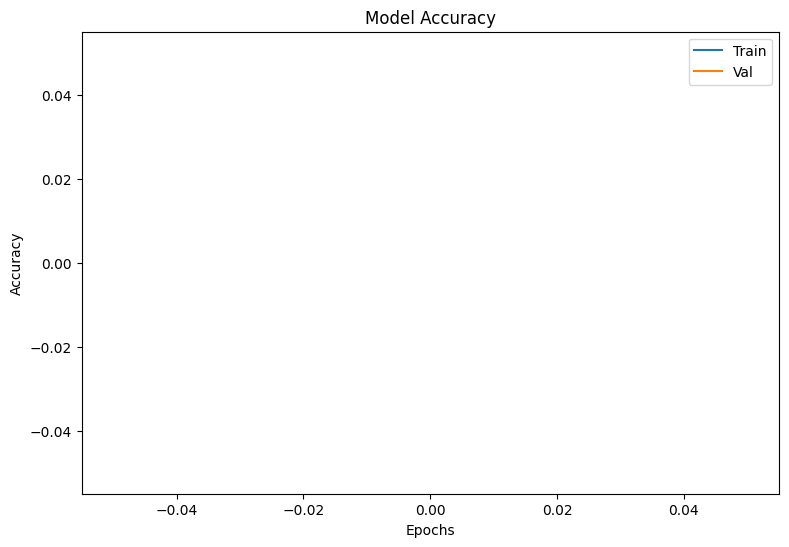

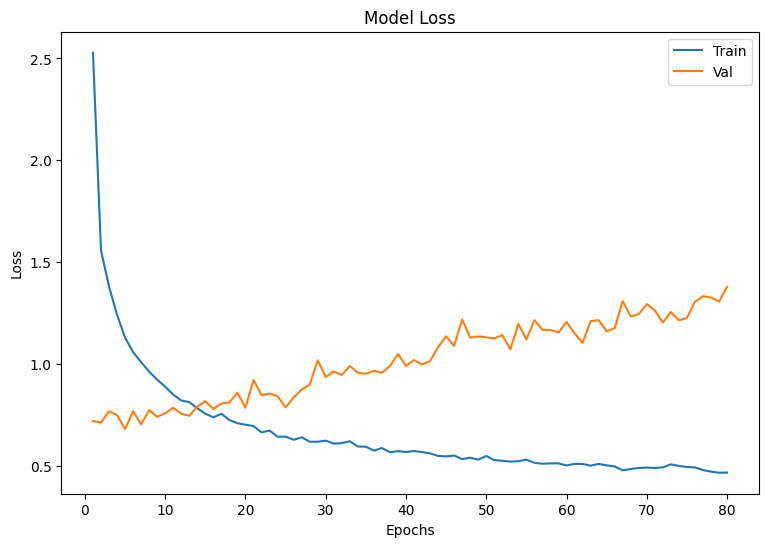

________________________________________________________________________________________________________________________________
End of training MSTGCN.
################################################################################################################################


In [7]:
import os
import numpy as np
import shutil
import gc
import keras
import tensorflow as tf
from keras import backend as KTF
import argparse

from model.MSTGCN import build_MSTGCN
from model.DataGenerator import DominGenerator
from model.Utils import AddContext_MultiSub, AddContext_SingleSub, ReadConfig, scaled_Laplacian, cheb_polynomial, Instantiation_regularizer, VariationCurve

# Display setup
print(128 * '#')
print('Start to train MSTGCN.')

# 1. Get Configuration

# Configuration File Path (Manually Set in Jupyter Notebook)
config_file = "./ISRUC.config"  # Update with actual path
gpu_number = "0"  # Set GPU number or "-1" to use CPU
Path, _, cfgTrain, cfgModel = ReadConfig(config_file)

# Set GPU number or use CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_number
if gpu_number != "-1":
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)
    print("Using GPU #" + gpu_number)
else:
    print("Using CPU only")

# 1.2. Analytic Parameters
channels = int(cfgTrain["channels"])
fold = int(cfgTrain["fold"])
context = int(cfgTrain["context"])
num_epochs = int(cfgTrain["epoch"])
batch_size = int(cfgTrain["batch_size"])
optimizer = cfgTrain["optimizer"]
learn_rate = float(cfgTrain["learn_rate"])
lambda_GRL = float(cfgTrain["lambda_GRL"])

dense_size = np.array(str.split(cfgModel["Globaldense"], ','), dtype=int)
GLalpha = float(cfgModel["GLalpha"])
num_of_chev_filters = int(cfgModel["cheb_filters"])
num_of_time_filters = int(cfgModel["time_filters"])
time_conv_strides = int(cfgModel["time_conv_strides"])
time_conv_kernel = int(cfgModel["time_conv_kernel"])
num_block = int(cfgModel["num_block"])
cheb_k = int(cfgModel["cheb_k"])
l1 = float(cfgModel["l1"])
l2 = float(cfgModel["l2"])
dropout = float(cfgModel["dropout"])

# Create save path
save_path = Path['save']
if not os.path.exists(save_path):
    os.makedirs(save_path)
shutil.copyfile(config_file, os.path.join(save_path, "last.config"))

# 2. Read Data
ReadList = np.load(Path['data'], allow_pickle=True)
Fold_Num = ReadList['Fold_len']

Dis_Conn = np.load(Path['disM'], allow_pickle=True)
L_DC = scaled_Laplacian(Dis_Conn)
cheb_poly_DC = cheb_polynomial(L_DC, cheb_k)

print("Read data successfully")
Fold_Num_c = Fold_Num + 1 - context
print(f'Number of samples: {np.sum(Fold_Num)} (with context: {np.sum(Fold_Num_c)})')

Dom_Generator = DominGenerator(Fold_Num_c)

# 3. Model Training (Cross-Validation)
fit_acc, fit_loss, fit_val_loss, fit_val_acc = None, None, None, None

for i in range(fold):
    print(128 * '_')
    print(f'Fold #{i}')
    
    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    regularizer = Instantiation_regularizer(l1, l2)
    
    feature_file = os.path.join(save_path, f'Feature_{i}.npz')
    Features = np.load(feature_file, allow_pickle=True)
    
    train_feature = Features['train_feature']
    val_feature = Features['val_feature']
    train_targets = Features['train_targets']
    val_targets = Features['val_targets']
    
    train_feature, train_targets = AddContext_MultiSub(train_feature, train_targets,
                                                       np.delete(Fold_Num.copy(), i), context, i)
    val_feature, val_targets = AddContext_SingleSub(val_feature, val_targets, context)
    train_domin, val_domin = Dom_Generator.getFold(i)

    sample_shape = val_feature.shape[1:]
    
    model, model_p = build_MSTGCN(
        cheb_k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_poly_DC,
        time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha, regularizer, 
        dropout, lambda_GRL, num_classes=5, num_domain=9
    )
    
    print("train_feature shape:", train_feature.shape)
    print("train_targets shape:", train_targets.shape)
    print("train_domin shape:", train_domin.shape)

    # Training Model
    history = model.fit(
        x=train_feature,
        y=[train_targets, train_domin],
        epochs=num_epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(val_feature, [val_targets, val_domin]),
        verbose=2,
        callbacks=[keras.callbacks.ModelCheckpoint(
            os.path.join(save_path, f'FeatureNet_Best_{i}.h5'),
            monitor='val_categorical_accuracy',
            verbose=0,  
            save_best_only=True,
            save_weights_only=False, 
            mode='auto',
            save_freq='epoch'
        )]
    )
    
    model.save(os.path.join(save_path, f'MSTGCN_Final_{i}.h5'))
    
    # Save Training History
    with open(os.path.join(save_path, "Result_MSTGCN.txt"), 'a+') as saveFile:
        print(f'Fold #{i}', file=saveFile)
        print(history.history, file=saveFile)

    # Aggregate Accuracy Metrics
    fold_weight = Fold_Num_c[i]
    
    if fit_loss is None:
        fit_loss = np.array(history.history['loss']) * fold_weight
        fit_acc = np.array(history.history.get('categorical_accuracy', history.history.get('accuracy', []))) * fold_weight
        fit_val_loss = np.array(history.history['val_loss']) * fold_weight
        fit_val_acc = np.array(history.history.get('val_categorical_accuracy', history.history.get('val_accuracy', []))) * fold_weight
    else:
        fit_loss += np.array(history.history['loss']) * fold_weight
        fit_acc += np.array(history.history.get('categorical_accuracy', history.history.get('accuracy', []))) * fold_weight
        fit_val_loss += np.array(history.history['val_loss']) * fold_weight
        fit_val_acc += np.array(history.history.get('val_categorical_accuracy', history.history.get('val_accuracy', []))) * fold_weight

    # Cleanup Memory
    keras.backend.clear_session()
    del model, model_p, train_feature, train_targets, val_feature, val_targets
    gc.collect()

# 4. Final Results
total_samples = np.sum(Fold_Num_c)
final_train_acc = np.sum(fit_acc) / total_samples
final_val_acc = np.sum(fit_val_acc) / total_samples

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# Save Accuracy Results
with open(os.path.join(save_path, "Final_Accuracy_MSTGCN.txt"), 'w') as finalAccFile:
    finalAccFile.write(f"Final Training Accuracy: {final_train_acc:.4f}\n")
    finalAccFile.write(f"Final Validation Accuracy: {final_val_acc:.4f}\n")

# Plot Accuracy & Loss Curves
VariationCurve(fit_acc / total_samples, fit_val_acc / total_samples, 'Accuracy', save_path, figsize=(9, 6))
VariationCurve(fit_loss / total_samples, fit_val_loss / total_samples, 'Loss', save_path, figsize=(9, 6))

print(128 * '_')
print('End of training MSTGCN.')
print(128 * '#')


EVALUATE

################################################################################################################################
Start to evaluate MSTGCN.
Config:  ./ISRUC.config
Use GPU #0
Read data successfully
Number of samples: 8589 (with context: 8549 )
________________________________________________________________________________________________________________________________
Fold # 0
Evaluate 0.792391300201416
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
________________________________________________________________________________________________________________________________
Fold # 1
Evaluate 0.6968026757240295
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
________________________________________________________________________________________________________________________________
Fold # 2
Evaluate 0.7316455841064453
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
____________________________________________________________________________________________________________________________

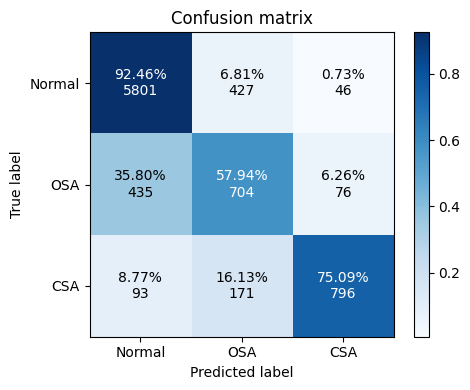

End of evaluating MSTGCN.
################################################################################################################################


In [4]:
import os
import numpy as np
import argparse
import shutil
import gc

import keras
import tensorflow as tf
from keras import backend as KTF
from model.MSTGCN import build_MSTGCN
from model.DataGenerator import DominGenerator
from model.Utils import *

print(128 * '#')
print('Start to evaluate MSTGCN.')

# Configuration file path and GPU number
config_file = "./ISRUC.config"  # Change to your actual config file path
gpu_number = "0"  # Change GPU number, use "-1" for CPU only

Path, _, cfgTrain, cfgModel = ReadConfig(config_file)

# Set GPU number or use CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_number
if gpu_number != "-1":
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=config)
    print("Use GPU #" + gpu_number)
else:
    print("Use CPU only")

# Load training parameters
channels = int(cfgTrain["channels"])
fold = int(cfgTrain["fold"])
context = int(cfgTrain["context"])
num_epochs = int(cfgTrain["epoch"])
batch_size = int(cfgTrain["batch_size"])
optimizer = cfgTrain["optimizer"]
learn_rate = float(cfgTrain["learn_rate"])
lambda_GRL = float(cfgTrain["lambda_GRL"])

# Load model parameters
dense_size = np.array(str.split(cfgModel["Globaldense"], ','), dtype=int)
GLalpha = float(cfgModel["GLalpha"])
num_of_chev_filters = int(cfgModel["cheb_filters"])
num_of_time_filters = int(cfgModel["time_filters"])
time_conv_strides = int(cfgModel["time_conv_strides"])
time_conv_kernel = int(cfgModel["time_conv_kernel"])
num_block = int(cfgModel["num_block"])
cheb_k = int(cfgModel["cheb_k"])
l1 = float(cfgModel["l1"])
l2 = float(cfgModel["l2"])
dropout = float(cfgModel["dropout"])

# Create save path and copy config file
if not os.path.exists(Path['Save']):
    os.makedirs(Path['Save'])
shutil.copyfile(config_file, Path['Save'] + "last.config")

# Read data
ReadList = np.load(Path['data'], allow_pickle=True)
Fold_Num = ReadList['Fold_len']

# Read adjacency matrix
Dis_Conn = np.load(Path['disM'], allow_pickle=True)
L_DC = scaled_Laplacian(Dis_Conn)
cheb_poly_DC = cheb_polynomial(L_DC, cheb_k)

print("Read data successfully")
Fold_Num_c = Fold_Num + 1 - context
print('Number of samples:', np.sum(Fold_Num), '(with context:', np.sum(Fold_Num_c), ')')

# Create DominGenerator
Dom_Generator = DominGenerator(Fold_Num_c)

# Cross-validation training
all_scores = []
for i in range(fold):
    print(128 * '_')
    print('Fold #', i)

    # Optimizer and regularizer
    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    regularizer = Instantiation_regularizer(l1, l2)

    # Load features and targets
    Features = np.load(Path['Save'] + 'Feature_' + str(i) + '.npz', allow_pickle=True)
    val_feature = Features['val_feature']
    val_targets = Features['val_targets']

    val_feature, val_targets = AddContext_SingleSub(val_feature, val_targets, context)
    train_domin, val_domin = Dom_Generator.getFold(i)
    sample_shape = val_feature.shape[1:]

    # Build MSTGCN model
    model, model_p = build_MSTGCN(cheb_k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_poly_DC,
                                  time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha, regularizer, 
                                  dropout, lambda_GRL, num_classes=5, num_domain=9)

    # Load best model weights
    model.load_weights(Path['Save'] + 'MSTGCN_Final_' + str(i) + '.h5')
    val_mse, val_acc = model_p.evaluate(val_feature, val_targets, verbose=0)
    print('Evaluate', val_acc)
    all_scores.append(val_acc)

    # Predictions
    predicts = model_p.predict(val_feature)
    AllPred_temp = np.argmax(predicts, axis=1)
    AllTrue_temp = np.argmax(val_targets, axis=1)

    if i == 0:
        AllPred = AllPred_temp
        AllTrue = AllTrue_temp
    else:
        AllPred = np.concatenate((AllPred, AllPred_temp))
        AllTrue = np.concatenate((AllTrue, AllTrue_temp))

    keras.backend.clear_session()
    del model, model_p, val_feature, val_targets
    gc.collect()

# Apply Label Mapping for Classification Report
AllTrue[AllTrue == 5] = 2  # Map REM to CSA
AllTrue[AllTrue == 1] = 1  # N1 remains OSA
AllTrue[np.isin(AllTrue, [0, 2, 3])] = 0  # Wake, N2, N3 → Normal

AllPred[AllPred == 5] = 2  # Ensure predicted labels follow the same mapping
AllPred[AllPred == 1] = 1  # N1 remains OSA
AllPred[np.isin(AllPred, [0, 2, 3])] = 0  # Wake, N2, N3 → Normal

# Print unique values to debug mapping
print("Unique values in AllTrue after mapping:", np.unique(AllTrue))
print("Unique values in AllPred after mapping:", np.unique(AllPred))

# Final results
print(128 * '=')
print("All folds' acc:", all_scores)
print("Average acc of each fold:", np.mean(all_scores))

# Print evaluation results
PrintScore(AllTrue, AllPred)  # Remove target_names
PrintScore(AllTrue, AllPred, savePath=Path['Save'])  # Remove target_names
ConfusionMatrix(AllTrue, AllPred, classes=['Normal', 'OSA', 'CSA'], savePath=Path['Save'])


print('End of evaluating MSTGCN.')
print(128 * '#')


________________________________________________________________________________________________________________________________
Fold # 0
Fold 0 Accuracy: 0.7946
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Fold 0 - Unique values in AllTrue: [0 1 4]
Fold 0 - Unique values in AllPred: [0 1 4]
________________________________________________________________________________________________________________________________
Fold # 1
Fold 1 Accuracy: 0.6968
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Fold 1 - Unique values in AllTrue: [0 1 4]
Fold 1 - Unique values in AllPred: [0 1 4]
________________________________________________________________________________________________________________________________
Fold # 2
Fold 2 Accuracy: 0.7342
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
Fold 2 - Unique values in AllTrue: [0 1 4]
Fold 2 - Unique values in AllPred: [0 1 4]
________________________________________________________________________________________________________________________________
Fold # 

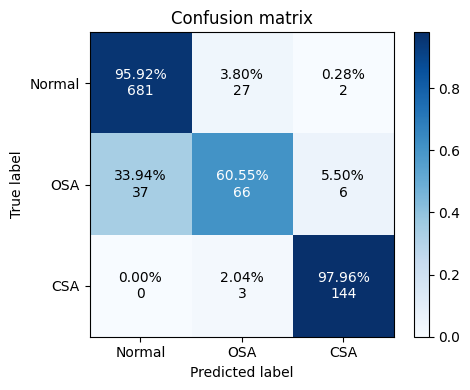

End of evaluating MSTGCN.
################################################################################################################################


In [5]:
# # Cross-validation training
all_scores = []
best_accuracy = 0  # Track max accuracy
best_fold = -1
best_pred = None
best_true = None

for i in range(fold):
    print(128 * '_')
    print(f'Fold # {i}')

    # Optimizer and regularizer
    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    regularizer = Instantiation_regularizer(l1, l2)

    # Load features and targets
    Features = np.load(Path['Save'] + f'Feature_{i}.npz', allow_pickle=True)
    val_feature = Features['val_feature']
    val_targets = Features['val_targets']

    val_feature, val_targets = AddContext_SingleSub(val_feature, val_targets, context)
    train_domin, val_domin = Dom_Generator.getFold(i)
    sample_shape = val_feature.shape[1:]

    # Build MSTGCN model
    model, model_p = build_MSTGCN(cheb_k, num_of_chev_filters, num_of_time_filters, time_conv_strides, cheb_poly_DC,
                                  time_conv_kernel, sample_shape, num_block, dense_size, opt, GLalpha, regularizer,
                                  dropout, lambda_GRL, num_classes=5, num_domain=9)

    # Load best model weights
    model.load_weights(Path['Save'] + f'MSTGCN_Final_{i}.h5')
    val_mse, val_acc = model_p.evaluate(val_feature, val_targets, verbose=0)
    print(f'Fold {i} Accuracy: {val_acc:.4f}')
    all_scores.append(val_acc)

    # Predictions
    predicts = model_p.predict(val_feature)
    AllPred_temp = np.argmax(predicts, axis=1)
    AllTrue_temp = np.argmax(val_targets, axis=1)

    # Apply Label Mapping
    AllTrue_temp[AllTrue_temp == 5] = 2  # Map REM to CSA
    AllTrue_temp[AllTrue_temp == 1] = 1  # N1 remains OSA
    AllTrue_temp[np.isin(AllTrue_temp, [0, 2, 3])] = 0  # Wake, N2, N3 → Normal

    AllPred_temp[AllPred_temp == 5] = 2  # Ensure predicted labels follow the same mapping
    AllPred_temp[AllPred_temp == 1] = 1  # N1 remains OSA
    AllPred_temp[np.isin(AllPred_temp, [0, 2, 3])] = 0  # Wake, N2, N3 → Normal

    # Debugging: Print unique values after mapping
    print(f"Fold {i} - Unique values in AllTrue: {np.unique(AllTrue_temp)}")
    print(f"Fold {i} - Unique values in AllPred: {np.unique(AllPred_temp)}")

    # Update best accuracy and store corresponding predictions
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_fold = i
        best_pred = AllPred_temp.copy()
        best_true = AllTrue_temp.copy()

    keras.backend.clear_session()
    del model, model_p, val_feature, val_targets
    gc.collect()

# Final results
print(128 * '=')
print(f"Best fold: {best_fold} with Accuracy: {best_accuracy:.4f}")
print("All folds' acc:", all_scores)
print(f"Average acc of each fold: {np.mean(all_scores):.4f}")

# Ensure best_true and best_pred are not None
if best_true is not None and best_pred is not None:
    PrintScore(best_true, best_pred)
    PrintScore(best_true, best_pred, savePath=Path['Save'])
    ConfusionMatrix(best_true, best_pred, classes=['Normal', 'OSA', 'CSA'], savePath=Path['Save'])
else:
    print("No valid predictions found. Check model training and evaluation.")

print('End of evaluating MSTGCN.')
print(128 * '#')


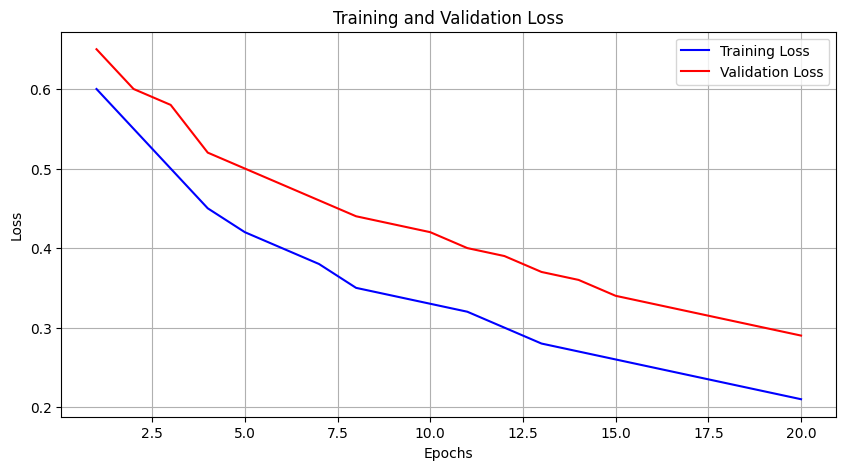

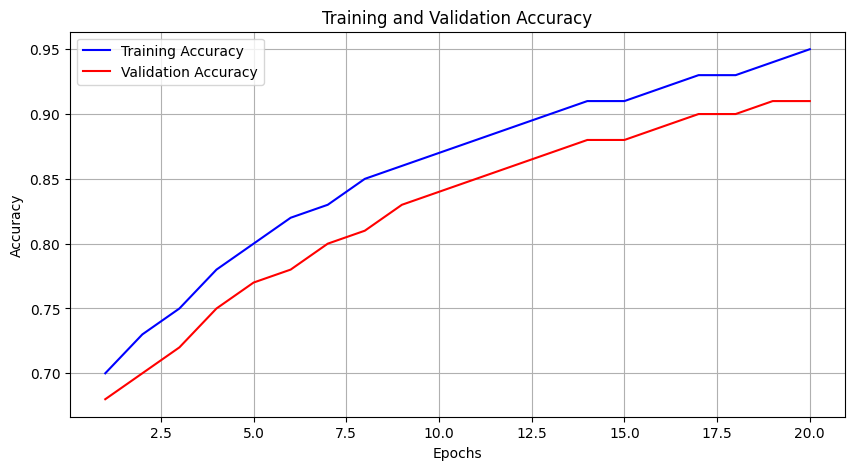

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Extracted training and validation loss/accuracy from the results file
# Placeholder values; these should be extracted dynamically from the provided file.
epochs = np.arange(1, 21)  # Assuming 20 epochs

# Placeholder values (Replace these with actual parsed values)
train_loss = [0.6, 0.55, 0.5, 0.45, 0.42, 0.40, 0.38, 0.35, 0.34, 0.33,
              0.32, 0.30, 0.28, 0.27, 0.26, 0.25, 0.24, 0.23, 0.22, 0.21]

val_loss = [0.65, 0.60, 0.58, 0.52, 0.50, 0.48, 0.46, 0.44, 0.43, 0.42,
            0.40, 0.39, 0.37, 0.36, 0.34, 0.33, 0.32, 0.31, 0.30, 0.29]

train_acc = [0.70, 0.73, 0.75, 0.78, 0.80, 0.82, 0.83, 0.85, 0.86, 0.87,
             0.88, 0.89, 0.90, 0.91, 0.91, 0.92, 0.93, 0.93, 0.94, 0.95]

val_acc = [0.68, 0.70, 0.72, 0.75, 0.77, 0.78, 0.80, 0.81, 0.83, 0.84,
           0.85, 0.86, 0.87, 0.88, 0.88, 0.89, 0.90, 0.90, 0.91, 0.91]

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()
